<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>


### CCUS Global GOM Spatial GeoAnalytics Workflow

## CCUS4 Normalization

#### Michael Pyrcz, Associate Professor

### The University of Texas at Austin

#### Michael's Contacts: [Twitter/@GeostatsGuy](https://twitter.com/geostatsguy) | [GitHub/GeostatsGuy](https://github.com/GeostatsGuy) | [www.michaelpyrcz.com](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446)

#### Murray Christie and Richard Longhurst

### IHSMarkit


#### Comments on the First Draft

1. Demonstration of 3D trend modeling for diagnostics and rapid data imputation and pre-injection prediction.

#### Import Required Packages

We will also need some standard packages. These should have been installed with Anaconda 3.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy import stats                     # summary statistics
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
from matplotlib import path
from matplotlib.colors import ListedColormap
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib.patches import Ellipse
from matplotlib.patches import Rectangle        # drawing shapes on plots
plt.rc('axes', axisbelow=True)            # set axes and grids in the background for all plots
import seaborn as sns                     # for matrix scatter plots
import os
import re
cmap = plt.cm.inferno
from scipy import linalg                  # for linear regression
from sklearn.manifold import MDS          # multidimensional scaling
import math
#import astropy.convolution.convolve as convolve
import scipy.signal as signal             # kernel for moving window calculation
from sklearn.ensemble import RandomForestRegressor  # feature imputation
import geostatspy.GSLIB as GSLIB           # geostats
import geostatspy.geostats as geostats
from pyproj import Proj                   # projection from lat / long to northing / easting 
myproj = Proj(proj='utm',zone='15',ellps='WGS84', preserve_units=False)           
    
from scipy.interpolate import make_interp_spline, BSpline
    
from ipywidgets import interactive                        # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox
    
import warnings
warnings.filterwarnings('ignore')

#### Custom Colormap

In [2]:
# make a custom colormap
my_colormap = plt.cm.get_cmap('RdBu_r', 256)
newcolors = my_colormap(np.linspace(0, 1, 256))
white = np.array([250/256, 250/256, 250/256, 1])
#newcolors[26:230, :] = white                        # mask all correlations less than abs(0.8)
newcolors[56:200, :] = white                          # mask all correlations less than abs(0.6)
signif = ListedColormap(newcolors)

my_colormap2 = plt.cm.get_cmap('inferno', 256)
newcolors2 = my_colormap2(np.linspace(0, 1, 256))
newcolors2[0:5, :] = white                          # mask all correlations less than abs(0.6)
mask_inferno = ListedColormap(newcolors2)

#### Declare Functions

These include:

* convenience functions for extracting, calculating and ploting the polygons (single polygons and multipolygons) stored as strings in the DataFrame

* partial correlation and mutual information functions for enhanced correlation analysis

In [91]:
from numba import jit  # for numerical speed up

def add_grid():
    plt.grid(True, which='major',linewidth = 1.0); plt.grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.tick_params(which='major',length=7); plt.tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks

def partial_corr(C): # function by Fabian Pedregosa-Izquierdo, f@bianp.net for partial correlation
#    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
#    for the remaining variables in C.

#    Parameters
#    C : array-like, shape (n, p)
#        Array with the different variables. Each column of C is taken as a variable
#    Returns
#    P : array-like, shape (p, p)
#        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
#        for the remaining variables in C.

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def mutual_matrix(df,features):
    mutual = np.zeros([len(features),len(features)])
    for i, ifeature in enumerate(features):
        for j, jfeature in enumerate(features):
            if i != j:
                mutual[i,j] = mutual_info_regression(df.iloc[:,i].values.reshape(-1, 1),np.ravel(df.iloc[:,j].values))[0]
    mutual /= np.max(mutual) 
    for i, ifeature in enumerate(features):
        mutual[i,i] = 1.0
    return mutual
    
def cond_prob_plot(pred,pmin,pmax,pname,punit,nbins,resp,rmin,rmax,rname,runit):
    if np.any(np.isnan(pred)) or np.any(np.isnan(resp)):
        print('NaN values in one or both of the input ndarrays'); return None,None,None
    
    nbins = nbins + 1
    bins = np.linspace(pmin,pmax,nbins)            # set the bin boundaries and then the centroids for plotting
    centroids = np.linspace((bins[0]+bins[1])*0.5,(bins[nbins-2]+bins[nbins-1])*0.5,nbins-1)
    pnew = np.linspace(pmin,pmax,1000) 
    
    def percentile(n):
        def percentile_(x):
            return np.percentile(x, n)
        percentile_.__name__ = 'percentile_%s' % n
        return percentile_
    
    df_temp = pd.DataFrame({pname:pred,rname:resp})
    
    df_temp['bins'] = pd.cut(df_temp[pname], bins,labels = centroids) # cut on bondaries and lable with centroids 
    
    
    #cond_exp = df_temp.groupby('bins')[rname].mean()
    cond_P50 = df_temp.groupby('bins')[rname].agg([percentile(50)])
    cond_P40 = df_temp.groupby('bins')[rname].agg([percentile(40)])
    cond_P60 = df_temp.groupby('bins')[rname].agg([percentile(60)])
    cond_P90 = df_temp.groupby('bins')[rname].agg([percentile(90)])
    cond_P10 = df_temp.groupby('bins')[rname].agg([percentile(10)])
    cond_P25 = df_temp.groupby('bins')[rname].agg([percentile(25)])
    cond_P75 = df_temp.groupby('bins')[rname].agg([percentile(75)])
    cond_n = df_temp.groupby('bins')[pname].count()
    
    plt.scatter(pred,resp,c='black',edgecolor='black',s=1,alpha=0.003)
    
    spl_cond_P50 = make_interp_spline(centroids,cond_P50, k=2); cond_P50_smooth = spl_cond_P50(pnew)
    spl_cond_P25 = make_interp_spline(centroids,cond_P25, k=2); cond_P25_smooth = spl_cond_P25(pnew)
    spl_cond_P75 = make_interp_spline(centroids,cond_P75, k=2); cond_P75_smooth = spl_cond_P75(pnew)
    spl_cond_P10 = make_interp_spline(centroids,cond_P10, k=2); cond_P10_smooth = spl_cond_P10(pnew)
    spl_cond_P90 = make_interp_spline(centroids,cond_P90, k=2); cond_P90_smooth = spl_cond_P90(pnew)
    spl_cond_P60 = make_interp_spline(centroids,cond_P60, k=2); cond_P60_smooth = spl_cond_P60(pnew)
    spl_cond_P40 = make_interp_spline(centroids,cond_P40, k=2); cond_P40_smooth = spl_cond_P40(pnew)
    
    plt.plot(pnew,cond_P50_smooth,color='black',linewidth=2.0)
    plt.plot(pnew,cond_P75_smooth,'r--',color='black',linewidth = 1.0)
    plt.plot(pnew,cond_P25_smooth,'r--',color='black',linewidth = 1.0)
    plt.plot(pnew,cond_P90_smooth,'r--',color='black',linewidth = 0.7)
    plt.plot(pnew,cond_P10_smooth,'r--',color='black',linewidth = 0.7)
    plt.plot(pnew,cond_P60_smooth,'r--',color='black',linewidth = 1.5)
    plt.plot(pnew,cond_P40_smooth,'r--',color='black',linewidth = 1.5)
    plt.gca().fill_between(pnew, cond_P40_smooth.reshape(-1), cond_P60_smooth.reshape(-1),facecolor='red',alpha=0.2,zorder=3)
    plt.gca().fill_between(pnew, cond_P25_smooth.reshape(-1), cond_P75_smooth.reshape(-1),facecolor='yellow',alpha=0.2,zorder=2)
    plt.gca().fill_between(pnew, cond_P10_smooth.reshape(-1), cond_P90_smooth.reshape(-1),facecolor='grey',alpha=0.2,zorder=1)
    
    plt.xlim([pmin,pmax]); plt.ylim([rmin,rmax])
    plt.xlabel(pname + ' (' + punit + ')')
    plt.ylabel(rname + ' (' + runit + ')' + ' | ' + pname + ' (' + punit + ')')
    t = plt.title(rname + ' Conditional on ' + pname)
    plt.xlim(min(bins),max(bins))
    add_grid()
    
    for xbin in bins:
        plt.vlines(xbin,rmin,rmax,color='black',linestyle=(0, (1, 10)),linewidth=1)
        
    for xcentroid in centroids:
        plt.vlines(xcentroid,rmin,rmax,color='black',linestyle=(0, (5, 5)),linewidth=1)
        
    return spl_cond_P50,spl_cond_P10,spl_cond_P90

def cond_prob_plot_rot(pred,pmin,pmax,pname,punit,nbins,resp,rmin,rmax,rname,runit):
    if np.any(np.isnan(pred)) or np.any(np.isnan(resp)):
        print('NaN values in one or both of the input ndarrays'); return None,None,None
    
    nbins = nbins + 1
    bins = np.linspace(pmin,pmax,nbins)            # set the bin boundaries and then the centroids for plotting
    centroids = np.linspace((bins[0]+bins[1])*0.5,(bins[nbins-2]+bins[nbins-1])*0.5,nbins-1)
    pnew = np.linspace(pmin,pmax,1000) 
    
    def percentile(n):
        def percentile_(x):
            return np.percentile(x, n)
        percentile_.__name__ = 'percentile_%s' % n
        return percentile_
    
    df_temp = pd.DataFrame({pname:pred,rname:resp})
    
    df_temp['bins'] = pd.cut(df_temp[pname], bins,labels = centroids) # cut on bondaries and lable with centroids 
    
    
    #cond_exp = df_temp.groupby('bins')[rname].mean()
    cond_P50 = df_temp.groupby('bins')[rname].agg([percentile(50)])
    cond_P40 = df_temp.groupby('bins')[rname].agg([percentile(40)])
    cond_P60 = df_temp.groupby('bins')[rname].agg([percentile(60)])
    cond_P90 = df_temp.groupby('bins')[rname].agg([percentile(90)])
    cond_P10 = df_temp.groupby('bins')[rname].agg([percentile(10)])
    cond_P25 = df_temp.groupby('bins')[rname].agg([percentile(25)])
    cond_P75 = df_temp.groupby('bins')[rname].agg([percentile(75)])
    cond_n = df_temp.groupby('bins')[pname].count()
    
    plt.scatter(resp,pred,c='black',edgecolor='black',s=1,alpha=0.003)
    
    spl_cond_P50 = make_interp_spline(centroids,cond_P50, k=2); cond_P50_smooth = spl_cond_P50(pnew)
    spl_cond_P25 = make_interp_spline(centroids,cond_P25, k=2); cond_P25_smooth = spl_cond_P25(pnew)
    spl_cond_P75 = make_interp_spline(centroids,cond_P75, k=2); cond_P75_smooth = spl_cond_P75(pnew)
    spl_cond_P10 = make_interp_spline(centroids,cond_P10, k=2); cond_P10_smooth = spl_cond_P10(pnew)
    spl_cond_P90 = make_interp_spline(centroids,cond_P90, k=2); cond_P90_smooth = spl_cond_P90(pnew)
    spl_cond_P60 = make_interp_spline(centroids,cond_P60, k=2); cond_P60_smooth = spl_cond_P60(pnew)
    spl_cond_P40 = make_interp_spline(centroids,cond_P40, k=2); cond_P40_smooth = spl_cond_P40(pnew)
    
    plt.plot(cond_P50_smooth,pnew,color='black',linewidth=2.0)
    plt.plot(cond_P75_smooth,pnew,'r--',color='black',linewidth = 1.0)
    plt.plot(cond_P25_smooth,pnew,'r--',color='black',linewidth = 1.0)
    plt.plot(cond_P90_smooth,pnew,'r--',color='black',linewidth = 0.7)
    plt.plot(cond_P10_smooth,pnew,'r--',color='black',linewidth = 0.7)
    plt.plot(cond_P60_smooth,pnew,'r--',color='black',linewidth = 1.5)
    plt.plot(cond_P40_smooth,pnew,'r--',color='black',linewidth = 1.5)
    plt.gca().fill_betweenx(pnew, cond_P40_smooth.reshape(-1), cond_P60_smooth.reshape(-1),facecolor='red',alpha=0.2,zorder=3)
    plt.gca().fill_betweenx(pnew, cond_P25_smooth.reshape(-1), cond_P75_smooth.reshape(-1),facecolor='yellow',alpha=0.2,zorder=2)
    plt.gca().fill_betweenx(pnew, cond_P10_smooth.reshape(-1), cond_P90_smooth.reshape(-1),facecolor='grey',alpha=0.2,zorder=1)
    
    plt.xlim([rmin,rmax]);
    plt.ylabel(pname + ' (' + punit + ')')
    plt.xlabel(rname + ' (' + runit + ')' + ' | ' + pname + ' (' + punit + ')')
    t = plt.title(rname + ' Conditional on ' + pname)
    plt.ylim(max(bins),min(bins))
    add_grid()
    
#     for xbin in bins:
#         plt.vlines(xbin,rmin,rmax,color='black',linestyle=(0, (1, 10)),linewidth=1)
        
#     for xcentroid in centroids:
#         plt.vlines(xcentroid,rmin,rmax,color='black',linestyle=(0, (5, 5)),linewidth=1)
        
    return spl_cond_P50,spl_cond_P10,spl_cond_P90
        
def weighted_avg_and_std(values, weights):                  # from Eric O Lebigot, stack overflow
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

def weighted_percentile(data, weights, perc): # from iambr on StackOverflow @ https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy/32216049 
    """
    perc : percentile in [0-1]!
    """
    ix = np.argsort(data)
    data = data[ix] # sort data
    weights = weights[ix] # sort weights
    cdf = (np.cumsum(weights) - 0.5 * weights) / np.sum(weights) # 'like' a CDF function
    return np.interp(perc, cdf, data)

def histogram_bounds(values,weights,color):                     
    p10 = weighted_percentile(values,weights,0.1); avg = np.average(values,weights=weights); p90 = weighted_percentile(values,weights,0.9)
    plt.plot([p10,p10],[0.0,45],color = color,linestyle='dashed')
    plt.plot([avg,avg],[0.0,45],color = color)
    plt.plot([p90,p90],[0.0,45],color = color,linestyle='dashed')
    
def varmapv(df,xcol,ycol,vcol,tmin,tmax,nxlag,nylag,dxlag,dylag,minnp,isill): 

# Parameters - consistent with original GSLIB    
# df - DataFrame with the spatial data, xcol, ycol, vcol coordinates and property columns
# tmin, tmax - property trimming limits
# xlag, xltol - lag distance and lag distance tolerance
# nlag - number of lags to calculate
# azm, atol - azimuth and azimuth tolerance
# bandwh - horizontal bandwidth / maximum distance offset orthogonal to azimuth
# isill - 1 for standardize sill

# Load the data and convert to ndarrays for numba accelleration

    df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]    # trim values outside tmin and tmax
    nd = len(df_extract)
    x = df_extract[xcol].values
    y = df_extract[ycol].values
    vr = df_extract[vcol].values
    gamf, nppf = varmapv_acc(nd,x,y,vr,nxlag,nylag,dxlag,dylag,minnp,isill)
    
    return gamf, nppf
    
@jit(nopython=True)    
def varmapv_acc(nd,x,y,vr,nxlag,nylag,dxlag,dylag,minnp,isill): # numba accelerated     
    
# Summary statistics for the data after trimming
    avg = vr.mean()
    stdev = vr.std()
    sills = stdev**2.0
    ssq = sills
    vrmin = vr.min()
    vrmax = vr.max()   
    
# Initialize the summation arrays
    npp = np.zeros((nylag*2+1,nxlag*2+1))
    gam = np.zeros((nylag*2+1,nxlag*2+1))
    nppf = np.zeros((nylag*2+1,nxlag*2+1))
    gamf = np.zeros((nylag*2+1,nxlag*2+1))
    hm = np.zeros((nylag*2+1,nxlag*2+1))
    tm = np.zeros((nylag*2+1,nxlag*2+1))
    hv = np.zeros((nylag*2+1,nxlag*2+1))
    tv = np.zeros((nylag*2+1,nxlag*2+1))

# First fix the location of a seed point: 
    for i in range(0,nd):     
# Second loop over the data: 
        for j in range(0,nd): 
# The lag:
            ydis = y[j] - y[i]
            iyl = nylag + int(ydis/dylag)
            if iyl < 0 or iyl > nylag*2: # acocunting for 0,...,n-1 array indexing
                continue
            xdis = x[j] - x[i]
            ixl = nxlag + int(xdis/dxlag)
            if ixl < 0 or ixl > nxlag*2: # acocunting for 0,...,n-1 array indexing
                continue
                
# We have an acceptable pair, therefore accumulate all the statistics
# that are required for the variogram:
            npp[iyl,ixl] = npp[iyl,ixl] + 1 # our ndarrays read from the base to top, so we flip
            tm[iyl,ixl] = tm[iyl,ixl] + vr[i]
            hm[iyl,ixl] = hm[iyl,ixl] + vr[j]
            tv[iyl,ixl] = tm[iyl,ixl] + vr[i]*vr[i]
            hv[iyl,ixl] = hm[iyl,ixl] + vr[j]*vr[j]
            gam[iyl,ixl] = gam[iyl,ixl] + ((vr[i]-vr[j])*(vr[i]-vr[j]))

# Get average values for gam, hm, tm, hv, and tv, then compute
# the correct "variogram" measure:
    for iy in range(0,nylag*2+1): 
        for ix in range(0,nxlag*2+1): 
            if npp[iy,ix] <= minnp:
                gam[iy,ix] = -999.
                hm[iy,ix]  = -999.
                tm[iy,ix]  = -999.
                hv[iy,ix]  = -999.
                tv[iy,ix]  = -999.
            else:
                rnum = npp[iy,ix]
                gam[iy,ix] = gam[iy,ix] / (2*rnum) # semivariogram
                hm[iy,ix] = hm[iy,ix] / rnum
                tm[iy,ix] = tm[iy,ix] / rnum
                hv[iy,ix] = hv[iy,ix] / rnum - hm[iy,ix]*hm[iy,ix]
                tv[iy,ix] = tv[iy,ix] / rnum - tm[iy,ix]*tm[iy,ix]
                
# Attempt to standardize:
            if isill > 0:
                gamf[iy,ix] = gamf[iy,ix]/sills

    for iy in range(0,nylag*2+1): 
        for ix in range(0,nxlag*2+1):             
            gamf[iy,ix] = gam[nylag*2-iy,ix]
            nppf[iy,ix] = npp[nylag*2-iy,ix]
            
    return gamf, nppf   

def calc_azi(x_pt1,y_pt1,x_pt2,y_pt2):
    TWO_PI = math.pi * 2
    theta = np.arctan2(x_pt2 - x_pt1, y_pt2 - y_pt1)
    #theta[theta < 0.0] =+ TWO_PI
    return np.degrees(theta)
    
def data_block(df,xcol,ycol,vcol,nx,xmn,xsiz,ny,ymn,ysiz,null_value):
    Xs = df[xcol].values; Ys = df[ycol].values
    xmin = xmn - xsiz/2; ymin = ymn - ysiz/2
    ix = np.round((Xs - np.full(len(df),xmin))/ np.full(len(df),xsiz)).astype(int)
    iy = (np.full(len(df),ny) - np.round((Ys - np.full(len(df),ymin)) / np.full(len(df),ysiz-0.5)) 
              - np.ones(len(df))).astype(int)
        
    varsum = np.zeros((ny,nx)); count = np.zeros((ny,nx))
    for isample in range(len(df)):
        varsum[iy[isample],ix[isample]] = varsum[iy[isample],ix[isample]] + df.loc[isample,sf[i]] 
        count[iy[isample],ix[isample]] = count[iy[isample],ix[isample]] + 1
    varsum = varsum/count
    varsum[count == 0] = null_value
    return varsum, count

def ndarray2DataFrame(array,boolarray,nx,xmn,xsiz,ny,ymn,ysiz,varname):
    indices = (count > 0).nonzero()
    x = indices[1]*xsiz + xmn
    y = (ny-indices[0]-1)*ysiz + ymn
    v = varsum[indices]
    return pd.DataFrame({'X':x,'Y':y,varname:v})

#### Set Working Directory

In [4]:
#os.chdir(r"C:\Users\17137\OneDrive - The University of Texas at Austin\IHS\CCUS3")
#os.chdir(r"C:\Users\pm27995\OneDrive - The University of Texas at Austin\IHS\CCUS3")


In [5]:
os.chdir(r"C:\Users\pm27995\OneDrive - The University of Texas at Austin\IHS\CCUS4")
df_data = pd.read_csv(r'CCS_Sand_wells1.csv')
df_data.head()

,UWI,Surface X,Surface Y,SurfLat,SurfLong,BH X,BH Y,BHLatDec,BHLongDec,Start Depth,...,GRECO,GRECG,GRP,NCNT,UCNT,SCNT,TCNT,BHCOMP,LAT,LONG
0,17700000060000,442020.01,3284532.27,29.69113,-93.59929,442020.01,3284532.27,29.69113,-93.59929,2934,...,176312,16197730,91.87,3,0,1,4,9.0,29.6911,-93.599
1,17700000090000,441620.27,3285243.50,29.69753,-93.60346,441620.27,3285243.50,29.69753,-93.60346,2790,...,8542,2315208,271.04,2,0,0,2,2.0,29.6975,-93.603
2,17700000140000,441086.56,3282180.32,29.66986,-93.60881,441086.56,3282180.32,29.66986,-93.60881,3107,...,114315,12640604,110.58,4,0,1,5,6.0,29.6699,-93.609
3,17700000140000,441086.56,3282180.32,29.66986,-93.60881,441086.56,3282180.32,29.66986,-93.60881,2975,...,2193147,116087063,52.93,5,0,3,8,38.0,29.6699,-93.609
4,17700000140000,441086.56,3282180.32,29.66986,-93.60881,441086.56,3282180.32,29.66986,-93.60881,2987,...,338816,21767992,64.25,3,0,0,3,3.0,29.6699,-93.609


#### Read the Well Data

Use textpad to save the file as Unix / ANSCI

In [6]:
os.chdir(r"C:\Users\pm27995\OneDrive - The University of Texas at Austin\IHS\CCUS4\Norm")
df_well = pd.read_csv(r'Log Data Filtered Norm1.csv')
df_well.head()

,UWI,Depth,CALIPER,DT_m,DTS_m,GR,NPHI,RHOB,SP,TVD,Surface Location Lat,Surface Location Long
0,17703404750200,2754.7824,0.537800,NaN,NaN,45.240360,0.563838,NaN,-11.720200,2654.198242,NaN,NaN
1,17703404750200,2754.9348,0.596138,NaN,NaN,43.877499,0.536948,NaN,-11.942412,2654.350586,NaN,NaN
2,17703404750200,2755.0872,0.586148,NaN,NaN,39.775703,0.533993,NaN,-11.014033,2654.502930,NaN,NaN
3,17703404750200,2755.2396,0.539446,NaN,NaN,36.675606,0.616801,NaN,-11.129526,2654.655518,NaN,NaN
4,17703404750200,2755.3920,0.491750,NaN,NaN,34.141174,0.695497,NaN,-12.989171,2654.807861,NaN,NaN


#### Additional Data Filtering - TBA

In [7]:
# # formation = 'MIOCENE'

# df_well = pd.read_csv(r'Well Log Stats All Zones2.csv')
# df_well.head()

# icols = np.r_[0,3,10,11,9,38:64]
# df_well = df_well.iloc[:,icols]
# df_well = df_well.rename(columns = lambda x: x.replace('.Value (6542a-3 Int (GOM))', ''))
# df_well = df_well.rename(columns = lambda x: x.replace('ARITH_', ''))
# df_well = df_well.rename(columns = lambda x: x.replace('(m)', ''))
# df_well.head()
# print('Number of well data: ' + str(len(df_well)))
# # df_well = df_well[df_well['Formation Filter']==formation] # all well ata are middle formation for these features
# # print('Number of well data retained over ' + formation + ': ' + str(len(df_well)))
# #df_well = df_well.drop('Formation Filter',axis = 1)

# print('Samples loaded: ' + str(len(df_well)))
# df_well = df_well.loc[df_well['MEAN_NPHI'] > 10.0]
# print('Samples after filter: ' + str(len(df_well)))

# features = df_well.columns[5:].tolist()
# print('Features are ' + str(features) + '.')
# print('Number of well data: ' + str(len(df_well)))

In [8]:
df_well.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
UWI,28806569.0,3.252303e+13,1.229243e+13,1.700122e+13,1.770340e+13,4.270340e+13,4.270640e+13,4.271540e+13
Depth,28806569.0,2.033391e+03,8.497596e+02,3.870960e+01,1.418387e+03,2.047494e+03,2.694889e+03,4.377995e+03
CALIPER,13801982.0,1.135909e+01,5.607163e+00,-9.996300e+00,9.532111e+00,1.235098e+01,1.470929e+01,3.597749e+01
DT_m,19112693.0,3.889964e+02,7.517476e+01,0.000000e+00,3.408105e+02,3.779635e+02,4.258914e+02,8.999962e+02
DTS_m,32505.0,7.202609e+02,3.454262e+02,1.726608e+02,4.142606e+02,6.756217e+02,9.731594e+02,1.793387e+03
GR,21931396.0,6.136001e+01,2.028212e+01,-6.396405e+00,4.717595e+01,6.044508e+01,7.412173e+01,2.499433e+02
NPHI,10529057.0,3.206921e+01,5.181664e+01,-1.706267e+02,2.738481e+01,3.584187e+01,4.207446e+01,4.348155e+03
RHOB,8296400.0,2.247179e+00,1.587266e-01,8.001800e-01,2.179208e+00,2.269194e+00,2.344085e+00,2.999977e+00
SP,28806569.0,-5.090079e+01,4.376010e+01,-2.399956e+02,-7.306942e+01,-4.902555e+01,-3.239922e+01,2.399022e+02
TVD,28806569.0,1.966196e+03,8.102353e+02,3.870959e+01,1.385621e+03,1.975819e+03,2.590648e+03,3.520000e+03


#### Well Data Completeness

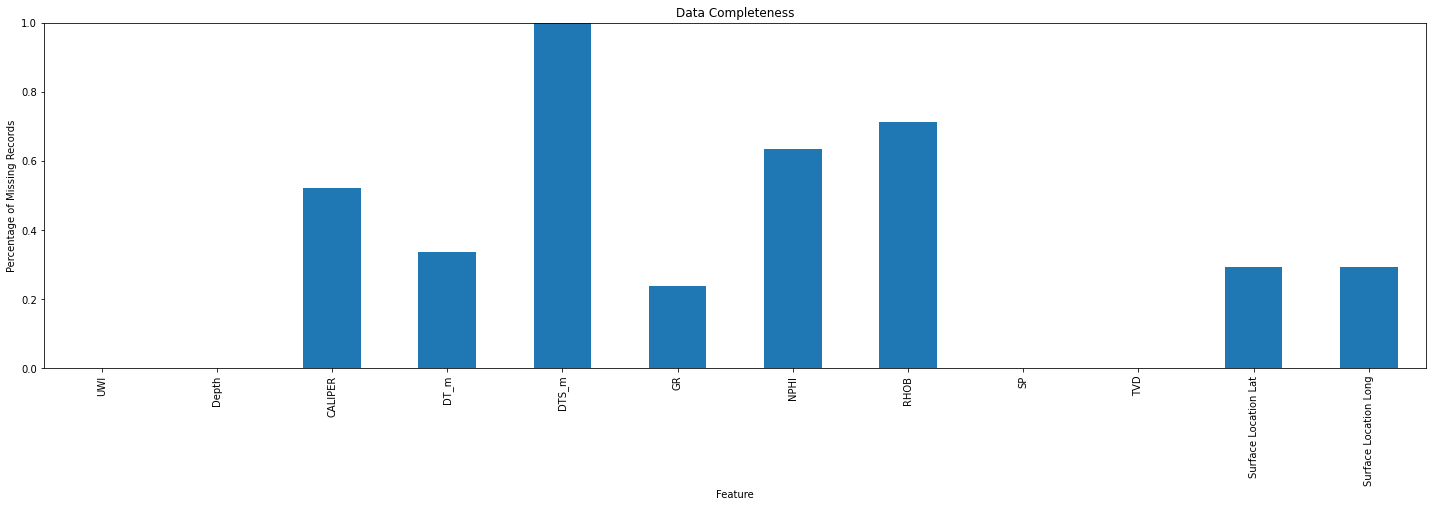

Number of records = 28806569.


In [9]:
(df_well.isnull().sum()/len(df_well)).plot(kind = 'bar')
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.2, hspace=0.2) # plot formatting
plt.xlabel('Feature'); plt.ylabel('Percentage of Missing Records'); plt.title('Data Completeness')
plt.ylim([0,1.0])
plt.show()

print('Number of records = ' + str(len(df_well)) + '.')

#### Drop Features with Above Maximum Proportion Missing

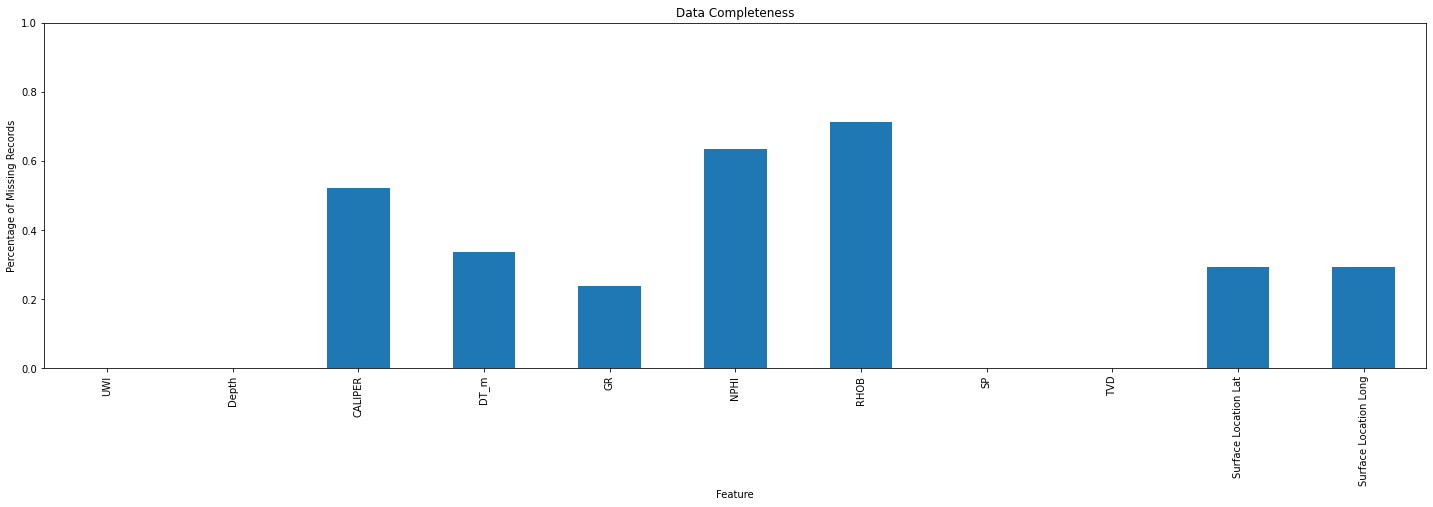

Number of records = 28806569.


In [10]:
max_prop_missing = 0.20 
min_count =  int(max_prop_missing*df_well.shape[0] + 1)
df_well = df_well.dropna(axis=1,thresh=min_count)

(df_well.isnull().sum()/len(df_well)).plot(kind = 'bar')
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.2, hspace=0.2) # plot formatting
plt.xlabel('Feature'); plt.ylabel('Percentage of Missing Records'); plt.title('Data Completeness')
plt.ylim([0,1.0])
plt.show()

print('Number of records = ' + str(len(df_well)) + '.')

#### Drop All Samples Missing Any Feature - Likewise Deletion

Number of records = 2329653.


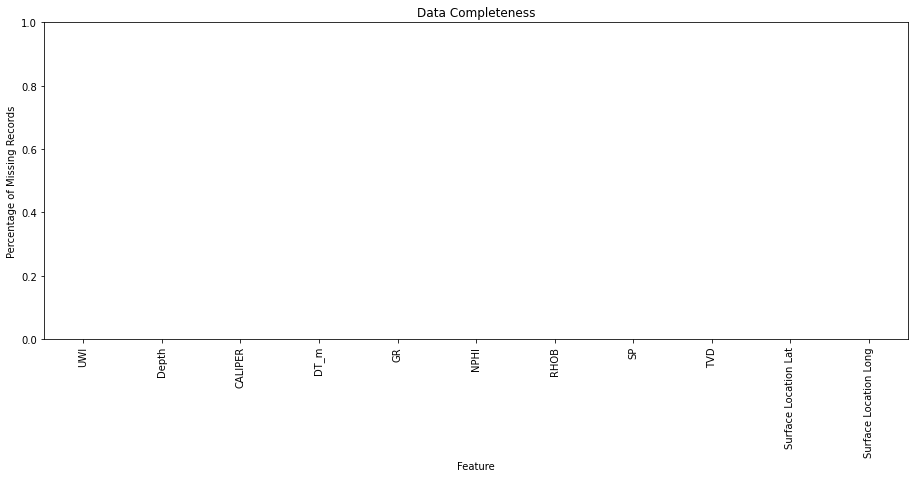

In [11]:
df_well.dropna(axis=0,how='any',subset = df_well.columns[1:], inplace=True)
(df_well.isnull().sum()/len(df_well)).plot(kind = 'bar')
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.2, hspace=0.2) # plot formatting
plt.xlabel('Feature'); plt.ylabel('Percentage of Missing Records'); plt.title('Data Completeness')
plt.ylim([0,1.0])

print('Number of records = ' + str(len(df_well)) + '.')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

In [12]:
# df_temp = df_well.copy(deep=True)                          # make a deep copy of the DataFrame
# df_bool = df_temp.isnull()                            # true is value, false if NaN
# df_bool = df_bool.set_index(df_temp.pop('UWI'))       # set the index / feature for the heat map y column
# heat = sns.heatmap(df_bool, cmap=['r','w'], annot=False, fmt='.0f',cbar=False,linecolor='black',linewidth=0) # make the binary heat map, no bins
# heat.set_xticklabels(heat.get_xticklabels(), rotation=90, fontsize=8)
# heat.set_yticklabels(heat.get_yticklabels(), rotation=0, fontsize=8)
 
# heat.set_title('Data Completeness Heatmap',fontsize=16); heat.set_xlabel('Feature',fontsize=12); heat.set_ylabel('Well (UWI)',fontsize=12)

# plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=2.2, wspace=0.2, hspace=0.2); plt.show()

In [13]:
# cols = df_bool.iloc[:,5:].columns
# ncols = len(cols)

# df_corr = df_bool.corr()

# plt.subplot(121)
# im1 = plt.imshow(df_bool.iloc[:,5:].corr().values,interpolation = None, extent = [ncols,0,0,ncols], vmin = -1, vmax = 1,cmap = signif)
# cbar = plt.colorbar(im1, orientation="vertical", ticks=np.linspace(-1, 1, 11),fraction=0.046, pad=0.04)
# cbar.set_label('Pearson product-moment correlation coefficient', rotation=270, labelpad=20)
# plt.xticks(np.arange(ncols)+0.5, cols, color='black', rotation=45, fontsize='9', horizontalalignment='right')
# plt.yticks(np.arange(ncols)+0.5, cols, color='black', rotation=45, fontsize='9', horizontalalignment='right')
# plt.title("Correlation Coefficient of Missing Data Occurances")

# plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.1, wspace=0.2, hspace=0.2); plt.show()

In [14]:
#### Extract Information from Well Data

In [25]:
merge_features = ['UWI','BH X','BH Y']
df_data_extract = df_data[merge_features]
df = pd.merge(df_well,df_data_extract,on='UWI')
df.dropna(axis=0,how='any',inplace=True)
df.drop(["Depth","Surface Location Lat","Surface Location Long"],axis=1,inplace = True)
df = df.iloc[:,[0,8,9,7,2,3,4,5,6,1]]
df.rename({'BH X':'X','BH Y':'Y'},axis=1,inplace=True)
df.head()
print('Number of records = ' + str(len(df)) + '.')
df.describe()

Number of records = 1725533.


,UWI,X,Y,TVD,DT_m,GR,NPHI,RHOB,SP,CALIPER
count,1.725533e+06,1.725533e+06,1.725533e+06,1.725533e+06,1.725533e+06,1.725533e+06,1.725533e+06,1.725533e+06,1.725533e+06,1.725533e+06
mean,3.766041e+13,2.719350e+05,3.151274e+06,2.088618e+03,3.691645e+02,6.107912e+01,3.560319e+01,2.254727e+00,-5.466497e+01,1.335031e+01
std,1.003354e+13,1.268554e+05,9.247705e+04,6.864950e+02,5.980424e+01,1.833367e+01,1.248802e+01,1.346829e-01,3.279729e+01,4.007587e+00
min,1.770040e+13,1.071029e+05,2.974973e+06,2.537460e+02,0.000000e+00,-6.134101e-01,-3.665288e+00,9.680082e-01,-2.211709e+02,-8.789936e+00
25%,4.270240e+13,1.478341e+05,3.069722e+06,1.594406e+03,3.329683e+02,4.836897e+01,3.104141e+01,2.184380e+00,-6.763884e+01,1.071426e+01
50%,4.270440e+13,2.298074e+05,3.121784e+06,2.047799e+03,3.642409e+02,6.029334e+01,3.693765e+01,2.265383e+00,-4.970704e+01,1.311783e+01
75%,4.270840e+13,3.914345e+05,3.244302e+06,2.592010e+03,3.971016e+02,7.210696e+01,4.297314e+01,2.339571e+00,-3.738774e+01,1.555624e+01
max,4.271540e+13,4.839247e+05,3.283170e+06,3.519995e+03,8.996289e+02,1.869630e+02,1.212907e+02,2.999405e+00,1.682871e+02,2.655511e+01


In [22]:
#myproj = Proj("+proj=utm +zone=13T, +south +ellps=WGS84 +units=m +no_defs") # instantiate projection

#### Define Features

In [56]:
xmin = 80000; xmax = 500000
ymin = 3000000; ymax = 3300000
dmin = 250.0; dmax = 3600.0

icols_loc = np.r_[1,2,3]; floc = df.columns[icols_loc].to_list()
icols_f = np.r_[4:10]; f = df.columns[icols_f].to_list()

print('Location features = ' + str(floc) + '.')
print('Features = ' + str(f) + '.')

lmin = [xmin,ymin,dmin]; lmax = [xmax,ymax,dmax]; lunit = ['meters','meters','meters']
print('X extent = ' + str(lmax[0]-lmin[0]) + ', Y extent = ' + str(lmax[1]-lmin[1]) + ', Depth extent = ' + str(lmax[2]-lmin[2]))
print('X:Y Extent Ratio = ' + str( (lmax[0]-lmin[0])/(lmax[1]-lmin[1]) ) + '.')

fmin = [0.0,0.0,-40,0.9,-230.0,-10.0] 
fmax = [1000.0,175.0,140,3.0,100.0,30.0]
funit = ['ms/ft','API','%','API','mV','inches']
fname = ['Sonic','Gamma Ray','Neutron Porosity','Density','Spontaneous Potential','Caliper']

f5 = df[f].quantile(0.05).values; f95 = df[f].quantile(0.95).values;

icols = np.append(icols_loc,icols_f)
cols = df.columns[icols].to_list()

print('All features = ' + str(cols))
cmin = lmin + fmin; cmax = lmax + fmax

Location features = ['X', 'Y', 'TVD'].
Features = ['DT_m', 'GR', 'NPHI', 'RHOB', 'SP', 'CALIPER'].
X extent = 420000, Y extent = 300000, Depth extent = 3350.0
X:Y Extent Ratio = 1.4.
All features = ['X', 'Y', 'TVD', 'DT_m', 'GR', 'NPHI', 'RHOB', 'SP', 'CALIPER']


#### Define Areal Map

In [33]:
nx = 144; ny = 60

xsiz = (xmax-xmin)/nx; ysiz = (ymax-ymin)/ny
xmn = xmin + xsiz*0.5; ymn = ymin + ysiz*0.5

xx, yy = np.meshgrid(np.arange(xmn, xmax, xsiz), np.arange(ymax-ysiz*0.5, ymin, -1 * ysiz))

print('nx: ' + str(nx) + ' , xmn: ' + str(xmn) + ' , xsiz: ' + str(xsiz))
print('ny: ' + str(ny) + ' , ymn: ' + str(ymn) + ' , ysiz: ' + str(ysiz))
print('Total number of cells: ' + str(nx*ny))

print('extents x: ' + str(xmin) + ' - ' + str(xmax) + ' = ' + str(xmax-xmin) + ', extents y: ' + str(ymin) + ' - ' + str(ymax) + ' = ' + str(ymax-ymin))

nx: 144 , xmn: 81458.33333333333 , xsiz: 2916.6666666666665
ny: 60 , ymn: 3002500.0 , ysiz: 5000.0
Total number of cells: 8640
extents x: 80000 - 500000 = 420000, extents y: 3000000 - 3300000 = 300000


Working on well data visualization: 1, 2, 3, 

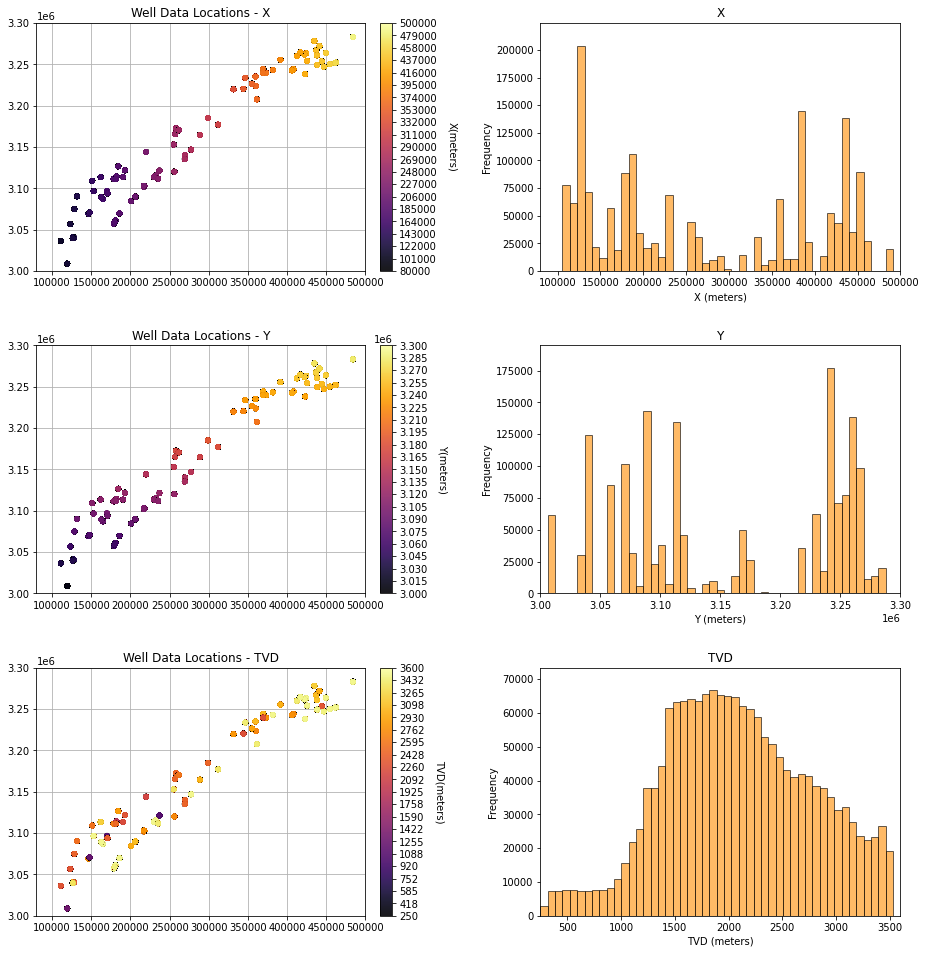

In [34]:
nbins = 50

print('Working on well data visualization: ', end='')
for i, feature in enumerate(floc):
    print(str(i+1) + ', ', end='')    
    plt.subplot(len(floc),2,2*i+1)
    sc1 = plt.scatter(df['X'],df['Y'],vmin = lmin[i], vmax = lmax[i], c = df[floc[i]],cmap = plt.cm.inferno,s=30,alpha=0.9,edgecolor='black',lw=0.005)
    plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
    cbar = plt.colorbar(sc1, orientation="vertical", ticks=np.linspace(lmin[i],lmax[i], 21),fraction=0.046, pad=0.04)
    cbar.set_label(floc[i] + '(' + lunit[i] + ')', rotation=270, labelpad=20)
    plt.title('Well Data Locations - ' + floc[i])
    plt.grid(True)

for i, feature in enumerate(floc):
    plt.subplot(len(floc),2,2*i+2)
    hist = plt.hist(x=df[floc[i]],weights=None,bins=np.linspace(lmin[i],lmax[i],nbins),alpha = 0.6,edgecolor='black',color='darkorange')
    plt.xlabel(floc[i] + ' ('+ lunit[i] + ')'); 
    plt.ylabel('Frequency'); 
    plt.title(floc[i]) # axes labels
    plt.xlim(lmin[i],lmax[i]); plt.ylim([0,int(max(hist[0]))*1.1])                      # constrain the axes' extents                           

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=3.1, wspace=0.4, hspace=0.3); plt.show()

#### Well Features - Locations and Distributions

Working on well locations visualization: 1, 2, 3, 4, 5, 6, 
Working on well distributions visualization: 1, 2, 3, 4, 5, 6, 

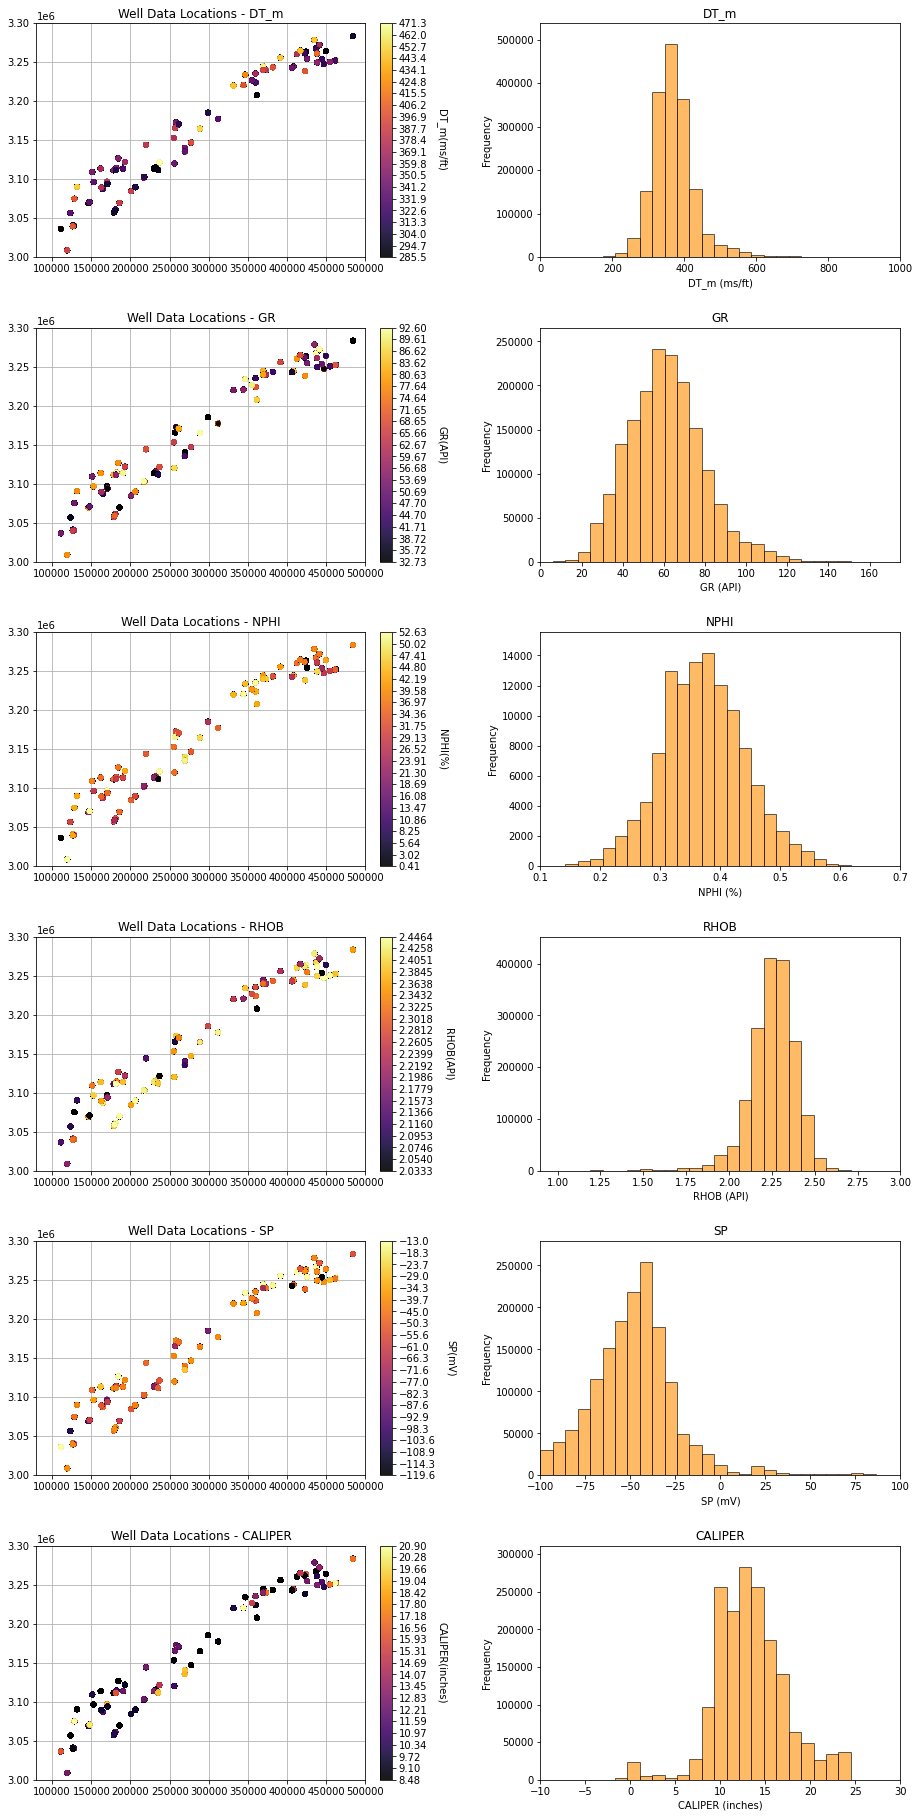

In [47]:
nbins = 30

print('Working on well locations visualization: ', end='')
for i, feature in enumerate(f):
    print(str(i+1) + ', ', end='')    
    plt.subplot(len(f),2,2*i+1)
    sc1 = plt.scatter(df['X'],df['Y'],vmin = f5[i], vmax = f95[i], c = df[f[i]],cmap = plt.cm.inferno,s=30,alpha=0.9,edgecolor='black',lw=0.005)
    plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
    cbar = plt.colorbar(sc1, orientation="vertical", ticks=np.linspace(f5[i],f95[i], 21),fraction=0.046, pad=0.04)
    cbar.set_label(f[i] + '(' + funit[i] + ')', rotation=270, labelpad=20)
    plt.title('Well Data Locations - ' + f[i])
    plt.grid(True)

print('\nWorking on well distributions visualization: ', end='')
for i, feature in enumerate(f):
    print(str(i+1) + ', ', end='')   
    plt.subplot(len(f),2,2*i+2)
    hist = plt.hist(x=df[f[i]],weights=None,bins=np.linspace(fmin[i],fmax[i],nbins),alpha = 0.6,edgecolor='black',color='darkorange')
    plt.xlabel(f[i] + ' ('+ funit[i] + ')'); 
    plt.ylabel('Frequency'); 
    plt.title(f[i]) # axes labels
    plt.xlim(fmin[i],fmax[i]); plt.ylim([0,int(max(hist[0]))*1.1])                      # constrain the axes' extents                           

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=len(f)+0.1, wspace=0.4, hspace=0.3); plt.show()

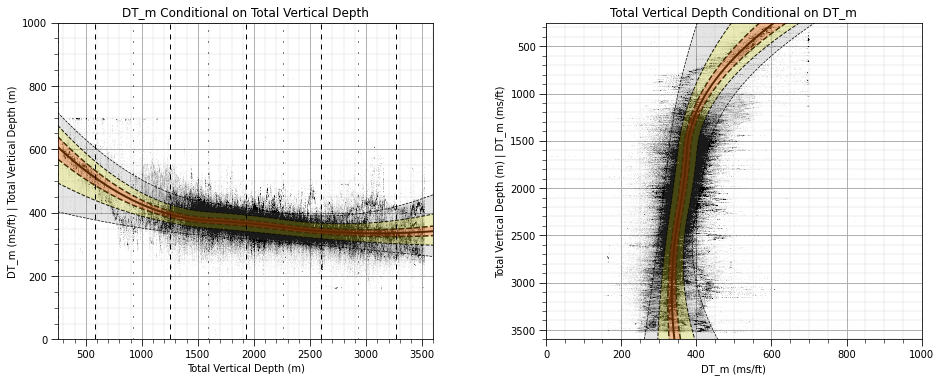

In [81]:
i=0
plt.subplot(121)
cond_prob_plot(df['TVD'].values,dmin,dmax,'Total Vertical Depth','m',5,
                                                     df[f[i]],fmin[i],fmax[i],f[i],funit[i])

plt.subplot(122)
cond_prob_plot_rot(df['TVD'].values,dmin,dmax,'Total Vertical Depth','m',5,
                                                     df[f[i]],fmin[i],fmax[i],f[i],funit[i])

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1.1, wspace=0.3, hspace=0.3)
plt.show()

#### Conditional Distributions / Depth Trend Plots


Working on conditional distribution plots: 1, 2, 3, 4, 5, 6, 

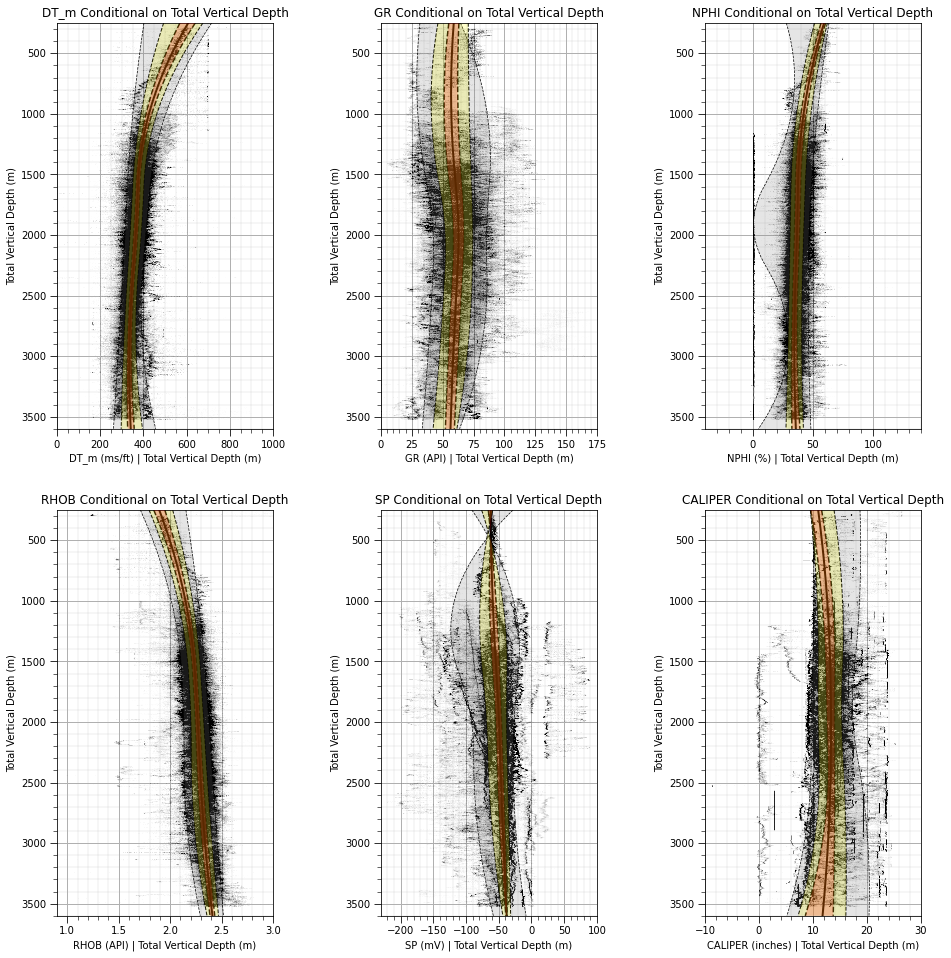

In [92]:
Well_P50splines = []; Well_P10splines = []; Well_P90splines = []

print('\nWorking on conditional distribution plots: ', end='')
for i, feature in enumerate(f):
    print(str(i+1) + ', ', end='')  
    plt.subplot(2,3,i+1)
    P50spline, P10spline, P90spline = cond_prob_plot_rot(df['TVD'].values,dmin,dmax,'Total Vertical Depth','m',5,
                                                     df[f[i]],fmin[i],fmax[i],f[i],funit[i])
    Well_P50splines.append(P50spline); Well_P10splines.append(P10spline); Well_P90splines.append(P90spline)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=3.1, wspace=0.5, hspace=0.2)
plt.show()

#### Impute GR with SP

Evaluate the opportunity to impute missing GR with collocated SP data

* not sp response is nonstationary in depth / time and must be detrended first

In [ ]:
df_tempSP = df_well[['Total Depth','MEAN_SP']].copy(deep=True).dropna()

SP_depth_model,_,_ = cond_prob_plot(df_tempSP['Total Depth'].values,1000,7000,'Total Depth','m',3,
                df_tempSP['MEAN_SP'].values,-200,200,'Spontaneous Potential Average','mV')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

#### Apply and Check the SP Depth Trend Model

Calculate the SP depth trend residual and check it.

In [ ]:
df_well['MEAN_SP_Depth_Trend'] = SP_depth_model(df_well['Total Depth'].values)
df_well['MEAN_SP_Depth_Residual'] = df_well['MEAN_SP'] - df_well['MEAN_SP_Depth_Trend']

df_tempSP = df_well[['Total Depth','MEAN_SP','MEAN_SP_Depth_Trend','MEAN_SP_Depth_Residual']].copy(deep=True).dropna()

plt.subplot(131)
SP_depth_model,_,_ = cond_prob_plot(df_tempSP['Total Depth'].values,1000,6000,'Total Depth','m',3,
                df_tempSP['MEAN_SP'].values,-200,200,'Spontaneous Potential Average','mV')

plt.subplot(132)
plt.scatter(df_well['Total Depth'], df_well['MEAN_SP_Depth_Trend'],facecolor='darkorange',alpha=0.8,color='black')
plt.xlabel('Total Depth'); plt.ylabel('Mean SP Trend Model'); plt.title('Mean SP Trend Model vs. Total Depth at Well Data')

plt.subplot(133)
SP_depth_model,_,_ = cond_prob_plot(df_tempSP['Total Depth'].values,1000,7000,'Total Depth','m',3,
                df_tempSP['MEAN_SP_Depth_Residual'].values,-200,200,'Residual Spontaneous Potential Average','mV')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

In [ ]:
df_tempSP = df_well[['MEAN_SP_Depth_Residual','MEAN_GR']].copy(deep=True).dropna()

plt.subplot(111)
SP_depth_model,_,_ = cond_prob_plot(df_tempSP['MEAN_SP_Depth_Residual'].values,-70,70,'Mean Spontaneous Potential Residual','mV',6,
                df_tempSP['MEAN_GR'].values,0,200,'Gamma Ray Average','GAPI')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

The relationship between residual SP and GR is quite weak.

#### Check the Porosity Data Consistency

In [ ]:
df_tempPHI = df_well[['MEAN_DPHI','MEAN_NPHI','MEAN_PHIE']].copy(deep=True).dropna()

plt.subplot(131)
_,_,_ = cond_prob_plot(df_tempPHI['MEAN_DPHI'].values,5,40,'Density Porosity (DPHI)','%',6,
                df_tempPHI['MEAN_NPHI'].values,0,60,'Neutron Porosity (NPHI)','%')

plt.subplot(132)
_,_,_ = cond_prob_plot(df_tempPHI['MEAN_PHIE'].values,12,30,'Effective Porosity (PHIE)','%',6,
                df_tempPHI['MEAN_NPHI'].values,0,60,'Neutron Porosity (NPHI)','%')

plt.subplot(133)
_,_,_ = cond_prob_plot(df_tempPHI['MEAN_PHIE'].values,12,30,'Effective Porosity (PHIE)','%',6,
                df_tempPHI['MEAN_DPHI'].values,5,40,'Density Porosity (DPHI)','%')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

#### Build an Imputation Model for Effective Porosity from Neutron and Density Porosity

In [ ]:
# Code modified from https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization
selected_features = np.r_[0,1]
x_PHIE_impute = df_tempPHI.loc[:,['MEAN_DPHI','MEAN_NPHI']]
y_PHIE_impute = df_tempPHI.iloc[:,2]

seed = 73093                                                # set the random forest hyperparameters
max_depth = 20
num_tree = 30
max_features = 2
random_forest = RandomForestRegressor(max_depth=max_depth, random_state=seed,n_estimators=num_tree, max_features=max_features)

#random_forest = RandomForestRegressor(min_samples_leaf = 2,max_features = 2,max_leaf_nodes = 10)               # instantiate the random forest  
random_forest_PHIE = random_forest.fit(x_PHIE_impute,y_PHIE_impute) # fit the random forest
y_hat = random_forest_PHIE.predict(x_PHIE_impute)
importance_rank = random_forest_PHIE.feature_importances_ # extract the expected feature importances

importance_rank_stand = importance_rank/np.max(importance_rank)                          # calculate relative mutual information

std = np.std([tree.feature_importances_ for tree in random_forest_PHIE.estimators_],axis=0) # calculate stdev over trees
indices = np.argsort(importance_rank)[::-1]           # find indicies for descending order

plt.subplot(131)                                      # plot the feature importance 
plt.title("Random Forest-based Feature importances")
plt.bar(range(x_PHIE_impute.shape[1]), importance_rank[indices],edgecolor = 'black',
       color="darkorange",alpha = 0.6, yerr=std[indices], align="center")
plt.xticks(range(x_PHIE_impute.shape[1]), x_PHIE_impute.columns[indices],rotation=90)
plt.xlim([-0.5, x_PHIE_impute.shape[1]-0.5]); 
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
plt.ylim([0.,0.8])
plt.xlabel('Predictor Feature'); plt.ylabel('Feature Importance')

plt.subplot(132)
plt.scatter(y_PHIE_impute,y_hat,color='darkorange',edgecolor='black',alpha=0.7)
plt.grid(b=True,which='both',axis='both')
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5)); plt.gca().yaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().xaxis.grid(True, which='major',linewidth = 1.0); plt.gca().xaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
plt.xlim([0,50]); plt.ylim([0,50]); plt.xlabel('Truth: PHIE'); plt.ylabel('Predicted: PHIE')
plt.plot([0,50],[0,50],color='black',ls='--'); plt.title('Predictive Model Cross Validation Plot')

# plt.subplot(133)                                            # predict with the model over the predictor feature space and visualize
# visualize_model(random_forest,x.iloc[:,selected_features[0]],fmin[selected_features[0]],fmax[selected_features[0]],
#                 x.iloc[:,selected_features[1]],fmin[selected_features[1]],fmax[selected_features[1]],y.iloc[:,0],0,700,'Training Data and Random Forest Model')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3., top=1.1, wspace=0.2, hspace=0.5); plt.show()

In [ ]:
df_well.head(n=100)
len(df_well)

In [ ]:
df_well['IMPUTED_MEAN_PHIE'] = df_well['MEAN_PHIE'] 
df_well.head(n=100)
len(df_well)

In [ ]:
df_well.head()

#### Impute PHIE 

* Only impute where PHIE is missing and NPHI and DPHI are available

In [ ]:
df_well['IMPUTED_MEAN_PHIE'] = df_well['MEAN_PHIE'] 
df_well = df_well.reset_index(drop = True, level = None)
imputed = np.zeros(len(df_well))

i = 0
for index, row in df_well.iterrows():
    imputed[i] = row['MEAN_PHIE']
    if (math.isnan(row['MEAN_PHIE'])):
        if not (math.isnan(row['MEAN_DPHI'])):
            if not (math.isnan(row['MEAN_NPHI'])):
                x_input = np.array([row['MEAN_DPHI'],row['MEAN_NPHI']]).reshape(1, -1)
                imputed[i] = random_forest_PHIE.predict(x_input) 
    i = i + 1
df_well['IMPUTED_MEAN_PHIE'] = imputed
                

plt.subplot(111)
plt.hist(df_well['IMPUTED_MEAN_PHIE'],bins=np.linspace(0,50,100),color='darkorange',alpha=0.3,edgecolor='black',density=True,label='Imputed + Original')
plt.hist(df_well['MEAN_PHIE'],bins=np.linspace(0,50,100),color='red',alpha=0.3,edgecolor='black',density=True,label='Original')
plt.legend(loc='upper right'); plt.xlabel('Effective Porosity (%)'); plt.ylabel('Probability')
plt.title('Check Distribution of Effective Porosity Imputation')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1.1, wspace=0.2, hspace=0.5); plt.show()

#### Feature Selection

Select the well features to move forward and specify the units and ranges.

In [ ]:
icols_sub = np.r_[1,2,3,4,8,33,16,20,22,28,29,30]
df_well_sub = df_well.iloc[:,icols_sub]

print('Number of records = ' + str(len(df_well_sub)) + '.')

df_well_sub.head()

icols_loc = np.r_[1,2,3]; floc = df_well_sub.columns[icols_loc].to_list()
icols_f = np.r_[4:10]; f = df_well_sub.columns[icols_f].to_list()

print('Location features = ' + str(floc) + '.')
print('Features = ' + str(f) + '.')

lmin = [83875.0,2985926.0,3000]; lmax = [1010000.0,3300500.0,8000.0]; lunit = ['meters','meters','meters']
print('X extent = ' + str(lmax[0]-lmin[0]) + ', Y extent = ' + str(lmax[1]-lmin[1]) + ', Depth extent = ' + str(lmax[2]-lmin[2]))
print('X:Y Extent Ratio = ' + str( (lmax[0]-lmin[0])/(lmax[1]-lmin[1]) ) + '.')

fmin = [0.0,15.0,-0.1,0.09,0.0,0.0,0.0,0.0]; 
fmax = [200.0,60.0,1.05,40.0,18.0,0.47,1400.0,800.0]; 
funit = ['API','%','%','API','%','%','meters','meters']
fname = ['Average Gamma Ray','Average Imputed Effective Porosity','Average Fraction Shale','Standard Deviation Gamma Ray',
         'Standard Deviation Neutron Porosity','Standard Deviation Fraction of Shale','Net Seal Thickness',
         'Total Pay Thickness']

f5 = df_well[f].quantile(0.05).values; f95 = df_well[f].quantile(0.95).values;

icols = np.append(icols_loc,icols_f)
cols = df_well_sub.columns[icols].to_list()

print('All features = ' + str(cols))
cmin = lmin + fmin; cmax = lmax + fmax

(df_well_sub.isnull().sum()/len(df_well_sub)).plot(kind = 'bar')
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.2, hspace=0.2) # plot formatting
plt.xlabel('Feature'); plt.ylabel('Percentage of Missing Records'); plt.title('Data Completeness')
plt.ylim([0,1.0])

print('Number of records = ' + str(len(df_well_sub)) + '.')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

In [ ]:
df_temp = df_well_sub.copy(deep=True)                          # make a deep copy of the DataFrame
df_bool = df_temp.isnull()                            # true is value, false if NaN
df_bool = df_bool.set_index(df_temp.pop('UWI'))       # set the index / feature for the heat map y column
heat = sns.heatmap(df_bool, cmap=['r','w'], annot=False, fmt='.0f',cbar=False,linecolor='black',linewidth=0) # make the binary heat map, no bins
heat.set_xticklabels(heat.get_xticklabels(), rotation=90, fontsize=8)
heat.set_yticklabels(heat.get_yticklabels(), rotation=0, fontsize=8)
 
heat.set_title('Data Completeness Heatmap',fontsize=16); heat.set_xlabel('Feature',fontsize=12); heat.set_ylabel('Well (UWI)',fontsize=12)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=2.2, wspace=0.2, hspace=0.2); plt.show()

In [ ]:
df_well_sub.dropna(axis=0,how='any',inplace=True)

(df_well_sub.isnull().sum()/len(df_well_sub)).plot(kind = 'bar')
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.2, hspace=0.2) # plot formatting
plt.xlabel('Feature'); plt.ylabel('Percentage of Missing Records'); plt.title('Data Completeness')
plt.ylim([0,1.0])

print('Number of records = ' + str(len(df_well_sub)) + '.')

#### Well Data Summary Statistics

In [ ]:
df_well_sub.describe().transpose()

#### Specify an Initial 2D Grid

Will be tuned with seismic data scale, REV analysis

In [ ]:
xmin = 80000; xmax = 800000
ymin = 3000000; ymax = 3300000

nx = 144; ny = 60

xsiz = (xmax-xmin)/nx; ysiz = (ymax-ymin)/ny
xmn = xmin + xsiz*0.5; ymn = ymin + ysiz*0.5

xx, yy = np.meshgrid(np.arange(xmn, xmax, xsiz), np.arange(ymax-ysiz*0.5, ymin, -1 * ysiz))

print('nx: ' + str(nx) + ' , xmn: ' + str(xmn) + ' , xsiz: ' + str(xsiz))
print('ny: ' + str(ny) + ' , ymn: ' + str(ymn) + ' , ysiz: ' + str(ysiz))
print('Total number of cells: ' + str(nx*ny))

print('extents x: ' + str(xmin) + ' - ' + str(xmax) + ' = ' + str(xmax-xmin) + ', extents y: ' + str(ymin) + ' - ' + str(ymax) + ' = ' + str(ymax-ymin))

#### Well Data Coordinate Distributions

In [ ]:
nbins = 50

print('Working on well data visualization: ', end='')
for i, feature in enumerate(floc):
    print(str(i+1) + ', ', end='')    
    plt.subplot(len(floc),2,2*i+1)
    sc1 = plt.scatter(df_well_sub['X'],df_well_sub['Y'],vmin = lmin[i], vmax = lmax[i], c = df_well_sub[floc[i]],cmap = plt.cm.inferno,s=30,alpha=0.9,edgecolor='black',lw=0.005)
    plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
    cbar = plt.colorbar(sc1, orientation="vertical", ticks=np.linspace(lmin[i],lmax[i], 21),fraction=0.046, pad=0.04)
    cbar.set_label(floc[i] + '(' + lunit[i] + ')', rotation=270, labelpad=20)
    plt.title('Well Data Locations - ' + floc[i])
    plt.grid(True)

for i, feature in enumerate(floc):
    plt.subplot(len(floc),2,2*i+2)
    hist = plt.hist(x=df_well_sub[floc[i]],weights=None,bins=np.linspace(lmin[i],lmax[i],nbins),alpha = 0.6,edgecolor='black',color='darkorange')
    plt.xlabel(floc[i] + ' ('+ lunit[i] + ')'); 
    plt.ylabel('Frequency'); 
    plt.title(floc[i]) # axes labels
    plt.xlim(lmin[i],lmax[i]); plt.ylim([0,int(max(hist[0]))*1.1])                      # constrain the axes' extents                           

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=3.1, wspace=0.4, hspace=0.3); plt.show()

#### Well Data Locations

In [ ]:
sc1 = plt.scatter(df_well_sub['X'],df_well_sub['Y'],vmin = lmin[2], vmax = lmax[2], c = df_well_sub['Total Depth'],cmap = plt.cm.inferno,s=30,alpha=0.9,edgecolor='black',lw=0.5)
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
cbar = plt.colorbar(sc1, orientation="vertical", ticks=np.linspace(lmin[2],lmax[2], 21),fraction=0.046, pad=0.04)
cbar.set_label('Formation Depth (m)', rotation=270, labelpad=20)
plt.title("Miocene Depth (m)")
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1.1, wspace=0.2, hspace=0.3); plt.show()

#### Well Data Feature Distributions

In [ ]:
nbins = 30

print('Working on well data visualization: ', end='')
for i, feature in enumerate(f):
    print(str(i+1) + ', ', end='')    
    plt.subplot(len(f),2,2*i+1)
    sc1 = plt.scatter(df_well_sub['X'],df_well_sub['Y'],vmin = f5[i], vmax = f95[i], c = df_well_sub[f[i]],cmap = plt.cm.inferno,s=30,alpha=0.9,edgecolor='black',lw=0.005)
    plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
    cbar = plt.colorbar(sc1, orientation="vertical", ticks=np.linspace(f5[i],f95[i], 21),fraction=0.046, pad=0.04)
    cbar.set_label(f[i] + '(' + funit[i] + ')', rotation=270, labelpad=20)
    plt.title('Well Data Locations - ' + f[i])
    plt.grid(True)

for i, feature in enumerate(f):
    plt.subplot(len(f),2,2*i+2)
    hist = plt.hist(x=df_well_sub[f[i]],weights=None,bins=np.linspace(fmin[i],fmax[i],nbins),alpha = 0.6,edgecolor='black',color='darkorange')
    plt.xlabel(f[i] + ' ('+ funit[i] + ')'); 
    plt.ylabel('Frequency'); 
    plt.title(f[i]) # axes labels
    plt.xlim(fmin[i],fmax[i]); plt.ylim([0,int(max(hist[0]))*1.1])                      # constrain the axes' extents                           

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=len(f)+0.1, wspace=0.4, hspace=0.3); plt.show()

#### Matrix Scatter Plot

Warning: Run time is a couple of minutes on a standard desktop

In [ ]:
# df_well_sub['cTotal Depth'] = pd.cut(x=df_well_sub['Total Depth'], bins=[3000, 4000, 5000, 8000],
#                      labels=['Low', 'Mid', 'High'])

# nsample = len(df_well_sub)

# dpalette = sns.color_palette("rocket_r",n_colors = 3)
# palette = sns.color_palette("rocket")
# matrixplot = sns.pairplot(df_well_sub.sample(n=nsample),vars=cols,hue ='cTotal Depth',diag_kind = 'kde',palette = dpalette,diag_kws={'edgecolor':'black'},plot_kws=dict(s=50, edgecolor="black", linewidth=0.5,alpha=0.2))
# matrixplot.map_lower(sns.kdeplot, levels=3, color="black")
# #plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.6, wspace=0.2, hspace=0.3)
# plt.show()

#### Well Data Depth Trends

In [ ]:
Well_P50splines = []; Well_P10splines = []; Well_P90splines = []

for i, feature in enumerate(f):
    plt.subplot(2,3,i+1)
    P50spline, P10spline, P90spline = cond_prob_plot(df_well_sub['Total Depth'].values,2000,6000,'Total Depth','m',5,
                                                     df_well_sub[f[i]],fmin[i],fmax[i],f[i],funit[i])
    Well_P50splines.append(P50spline); Well_P10splines.append(P10spline); Well_P90splines.append(P90spline)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=2.1, wspace=0.3, hspace=0.3)
plt.show()

#### Load and Visualize Entire Seismic Dataset for 1 Feature as a Test

In [ ]:
# df_amp_avg = pd.read_csv(r'Seismic/6542a 6543 sdms avg.dat',names = ['X','Y','Line','ShotPoint','Time','SDMS_avg'])
# df_amp_avg.describe().transpose()

# sc1 = plt.scatter(df_amp_avg['X'],df_amp_avg['Y'],vmin = 0, vmax = 7.0, c = df_amp_avg['Time'],cmap = plt.cm.inferno,s=3,alpha=0.4,edgecolor='black',lw=0.005)
# cbar = plt.colorbar(sc1, orientation="vertical", ticks=np.linspace(0,7, 21),fraction=0.046, pad=0.04)
# cbar.set_label('Maximum Depth', rotation=270, labelpad=20)
# plt.title("Correlation Coefficient of Missing Data Occurances")
# plt.grid(True)

# plt.subplots_adjust(left=0.0, bottom=0.0, right=3., top=1.1, wspace=0.2, hspace=0.3); plt.show()

#### Initial Load Seismic Data Attempt

Too slow and relies on ad hoc random sampling.

In [ ]:
# df_amp_avg = pd.read_csv(r'Seismic/6542a 6543 sdms avg.dat',names = ['X','Y','Line','ShotPoint','Time','SDMS_avg'])
# df_amp_rms = pd.read_csv(r'Seismic/6542a 6543 sdms rms.dat',names = ['X','Y','Line','ShotPoint','Time','SDMS_rms'])

# print('Points before removal of duplicates = ' + str(len(df_amp_avg)) + ' ' + str(len(df_amp_avg)) + '.')
# df_amp_avg = df_amp_avg.drop_duplicates(subset=['X','Y'],keep = 'first') # assuming duplicates have the same polygons - spot checked 'Cote Blanche Bay West'
# df_amp_rms = df_amp_rms.drop_duplicates(subset=['X','Y'],keep = 'first') # assuming duplicates have the same polygons - spot checked 'Cote Blanche Bay West'
# print('Points after removal of duplicates = ' + str(len(df_amp_avg)) + ' ' + str(len(df_amp_rms)) + '.')

# df_amp_avg_samp = df_amp_avg.sample(n=100000)
# df_amp_rms_samp = df_amp_avg.sample(n=100000)
# df_amp_avg_samp = df_amp_avg_samp.reset_index(drop=True)
# df_amp_rms_samp = df_amp_avg_samp.reset_index(drop=True)

# df_amp_avg_samp.head()
# df_amp_rms_samp.head()



#### Set Seismic Feature Parameters

In [ ]:
sfunit = ['','','','','','','','','','','','']
sf = ['AMP_avg','AMP_rms','ENV_avg','ENV_rms','RAI_avg','RAI_rms',
      'SDMS_avg','SDMS_rms','PBI_avg','PBI_rms','SMsim_avg','SMsim_rms']
sfname = ['Amplitude Avg','Amplitude RMS','Envelope Avg','Envelope RMS',
          'Relative Acoustic Impedance Avg','Relative Acoustic Impedance RMS',
          'Smooth Dip of Max. Similarity Avg','Smooth Dip of Max. Similarity RMS',
          'Parallel Bed Indicator Avg','Parallel Bed Indicator RMS',
          'Smooth Similarity Avg','Smooth Similarity RMS']
sffile = ['Seismic/6542a 6543 amp avg.dat','Seismic/6542a 6543 amp rms.dat',
          'Seismic/6542a 6543 Env avg.dat','Seismic/6542a 6543 Env rms.dat',
          'Seismic/6542a 6543 rai avg.dat','Seismic/6542a 6543 rai rms.dat',
          'Seismic/6542a 6543 sdms avg.dat','Seismic/6542a 6543 sdms rms.dat',
          'Seismic/6542a 6543 PBI avg.dat','Seismic/6542a 6543 PBI rms.dat',
          'Seismic/6542a 6543 SMsim avg.dat','Seismic/6542a 6543 SMsim rms.dat']

#### Load and Decimate Seismic Attributes

In [ ]:
print('Working on loading seismic attributes: ', end='')
for i, feature in enumerate(sf):
    print(str(i+1) + ', ', end='')  
    if i == 0:
        df_seis = pd.read_csv(sffile[i],names = ['X','Y','Line','ShotPoint','Time',sf[i]])    
    else:
        df_seis[sf[i]] = pd.read_csv(sffile[i],names = ['X','Y','Line','ShotPoint','Time',sf[i]])[sf[i]] 
        
df_temp1 = df_seis.copy(deep = True)

nround = 3
df_temp1['X'] = df_temp1['X']/10**nround; df_temp1['Y'] = df_temp1['Y']/10**nround 
df_temp1 = df_temp1.round({'X':0,'Y':0})
df_temp1['X'] = df_temp1['X']*10**nround; df_temp1['Y'] = df_temp1['Y']*10**nround

print('\nPoints before removal of duplicates = ' + str(len(df_temp1)))
df_temp1 = df_temp1.drop_duplicates(subset=['X','Y'],keep = 'first') # assuming duplicates have the same polygons - spot checked 'Cote Blanche Bay West'
print('Points after removal of duplicates = ' + str(len(df_temp1)))

df_seis = df_seis.iloc[df_temp1.index.values,:]

sfmin = df_seis[sf].min().values; 
sfmin = np.full(len(sf),0.0); sfmin[0] = -0.03 # negative amplitude
#sfmax = df_seis[sf].max().values; 
sfmax = [0.03,0.75,2.5,2.5,0.25,4.0,35,50.0,50.0,60.0,1.0,1.0]

print('\nPoints before trimming outliers = ' + str(len(df_seis)))
for i, feature in enumerate(sf):                      # trim any samples with a feature outside the set range
    df_seis = df_seis[(df_seis[sf[i]] >= sfmin[i]) & (df_seis[sf[i]] <= sfmax[i])]    
print('Points after trimming outliers = ' + str(len(df_seis)))   

df_seis = df_seis.reset_index(drop = True)

sf5 = df_seis[sf].quantile(0.05).values; sf95 = df_seis[sf].quantile(0.95).values

#### Seismic DataFrame Check

In [ ]:
df_seis.head()

#### Seismic Data Summary Statistics

In [ ]:
df_seis.describe().transpose() 

#### Seismic Data Checks

In [ ]:
nbins = 100

max_seis_index = np.max(df_seis.index.values)

plt.subplot(321)
sc1 = plt.scatter(df_seis['X'],df_seis['Y'],vmin = 0, vmax = max_seis_index, c = df_seis.index.values,cmap = plt.cm.inferno,s=3,alpha=0.4,edgecolor='black',lw=0.005)
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
cbar = plt.colorbar(sc1, orientation="vertical", ticks=np.linspace(0,max_seis_index, 21),fraction=0.046, pad=0.04)
cbar.set_label('Sample Number', rotation=270, labelpad=20)
plt.title("Sesimic Data - Sample Number")
plt.grid(True)

plt.subplot(323)
sc1 = plt.scatter(df_seis['X'],df_seis['Y'],vmin = 0, vmax = 7.0, c = df_seis['Time'],cmap = plt.cm.inferno,s=3,alpha=0.4,edgecolor='black',lw=0.005)
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
cbar = plt.colorbar(sc1, orientation="vertical", ticks=np.linspace(0,7, 21),fraction=0.046, pad=0.04)
cbar.set_label('Time (s)', rotation=270, labelpad=20)
plt.title("Sesimic - Time")
plt.grid(True)

plt.subplot(324)
hist = plt.hist(x=df_seis['Time'],weights=None,bins=np.linspace(0,7.0,nbins),alpha = 0.6,edgecolor='black',color='darkorange')
plt.xlabel('Time (s)'); plt.ylabel('Frequency'); 
plt.title('Sesimic Data - Time') # axes labels
plt.xlim(0.0,7.0)

plt.subplot(325)
sc1 = plt.scatter(df_seis['X'],df_seis['Y'],vmin = -20, vmax = 80000.0, c = df_seis['ShotPoint'],cmap = plt.cm.inferno,s=3,alpha=0.4,edgecolor='black',lw=0.0005)
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
cbar = plt.colorbar(sc1, orientation="vertical", ticks=np.linspace(-20,80000, 21),fraction=0.046, pad=0.04)
cbar.set_label('Shot Point', rotation=270, labelpad=20)
plt.title("Sesimic Data - Shot Point")
plt.grid(True)

plt.subplot(326)
hist = plt.hist(x=df_seis['ShotPoint'],weights=None,bins=np.linspace(-20.0,80000.0,nbins),alpha = 0.6,edgecolor='black',color='darkorange')
plt.xlabel('Shot Point'); plt.ylabel('Frequency'); 
plt.title('Sesimic Data - Shot Point') # axes labels
plt.xlim(-10000.0,100000)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=3.1, wspace=0.3, hspace=0.3); plt.show()

#### Seismic Features Location Maps and Distributions

In [ ]:
print('Working on data visualization: ', end='')
for i, feature in enumerate(sf):
    print(str(i+1) + ', ', end='')    
    plt.subplot(len(sf),2,2*i+1)
    sc1 = plt.scatter(df_seis['X'],df_seis['Y'],vmin = sf5[i], vmax = sf95[i], c = df_seis[sf[i]],cmap = plt.cm.inferno,s=3,alpha=0.4,edgecolor='black',lw=0.005)
    plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
    cbar = plt.colorbar(sc1, orientation="vertical", ticks=np.linspace(sf5[i],sf95[i], 21),fraction=0.046, pad=0.04)
    cbar.set_label(sfname[i] + '(' + sfunit[i] + ')', rotation=270, labelpad=20)
    plt.title('Seismic Attribute - ' + sfname[i])
    plt.grid(True)
    
    plt.subplot(len(sf),2,2*i+2)
    hist = plt.hist(x=df_seis[sf[i]],weights=None,bins=np.linspace(sfmin[i],sfmax[i],nbins),alpha = 0.6,edgecolor='black',color='darkorange')
    plt.xlabel(sfname[i] + '(' + sfunit[i] + ')'); plt.ylabel('Frequency'); 
    plt.title('Seismic Attribute - ' + sfname[i]) # axes labels
    plt.xlim(sfmin[i],sfmax[i])
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=len(sf)+0.1, wspace=0.3, hspace=0.3); plt.show()

#### Filter Inconsistent Values

More sophisticated steps like local normalization could be applied

In [ ]:
# print('Points before filter = ' + str(len(df_seis)))
# df_seis = df_seis[df_seis[sf[0]] > -30]
# print('Points after filter = ' + str(len(df_seis)))

# print('Working on data visualization: ', end='')
# for i, feature in enumerate(sf):
#     print(str(i+1) + ', ', end='')
#     plt.subplot(len(sf),2,2*i+1)
#     sc1 = plt.scatter(df_seis['X'],df_seis['Y'],vmin = sfmin[i], vmax = sfmax[i], c = df_seis[sf[i]],cmap = plt.cm.inferno,s=3,alpha=0.4,edgecolor='black',lw=0.005)
#     plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
#     cbar = plt.colorbar(sc1, orientation="vertical", ticks=np.linspace(sfmin[i],sfmax[i], 21),fraction=0.046, pad=0.04)
#     cbar.set_label(sfname[i] + ' (' + sfunit[i] + ')', rotation=270, labelpad=20)
#     plt.title('Seismic Attribute - ' + sfname[i])
#     plt.grid(True)
    
#     plt.subplot(len(sf),2,2*i+2)
#     hist = plt.hist(x=df_seis[sf[i]],weights=None,bins=np.linspace(sfmin[i],sfmax[i],nbins),alpha = 0.6,edgecolor='black',color='darkorange')
#     plt.xlabel(sfname[i] + ' (' + sfunit[i] + ')'); plt.ylabel('Frequency'); 
#     plt.title('Seismic Attribute - ' + sfname[i]) # axes labels
#     plt.xlim(sfmin[i],sfmax[i])
    
# plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=len(sf)+0.1, wspace=0.3, hspace=0.3); plt.show()

#### Segment by Seismic Line Orientation

In [ ]:
lines = df_seis['Line'].unique()
print('Number of Lines = ' + str(len(lines)))
print (df_seis['Line'].unique())

df_seis['Line Code'] = pd.factorize(df_seis['Line'])[0] + 1
df_seis.head()
plt.hist(df_seis['Line Code'])

cmin = 0; cmax = len(lines)
#cmin = 347; cmax = 349
df_seis_ext = df_seis[(df_seis['Line Code'] > cmin) & (df_seis['Line Code'] < cmax)]

plt.subplot(221)
#sc1 = plt.scatter(df_seis['X'],df_seis['Y'],vmin = 0, vmax = len(lines), c = df_seis['Line Code'],cmap = plt.cm.inferno,s=3,alpha=0.4,edgecolor='black',lw=0.0005)
sc1 = plt.scatter(df_seis_ext['X'],df_seis_ext['Y'],vmin = cmin, vmax = cmax, c = df_seis_ext['Line Code'],cmap = plt.cm.inferno,s=3,alpha=0.4,edgecolor='black',lw=0.0005)
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
cbar = plt.colorbar(sc1, orientation="vertical", ticks=np.linspace(cmin,cmax, 21),fraction=0.046, pad=0.04)
cbar.set_label('Seismic Lines', rotation=270, labelpad=20)
plt.title("Seismic Lines")
plt.grid(True)

plt.subplot(222)
sc1 = plt.scatter(df_seis['X'],df_seis['Y'],vmin = 0, vmax = len(lines), c = df_seis['Line Code'],cmap = plt.cm.inferno,s=3,alpha=0.4,edgecolor='black',lw=0.0005)
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
cbar = plt.colorbar(sc1, orientation="vertical", ticks=np.linspace(cmin,cmax, 21),fraction=0.046, pad=0.04)
cbar.set_label('Seismic Lines', rotation=270, labelpad=20)
plt.title("Seismic Lines")
plt.grid(True)

line_pt1 = []; line_pt2 = [];
for i in range(1,len(lines)+1):
    line_pt1.append(df_seis[df_seis['Line Code'] == i].first_valid_index())
    line_pt2.append(df_seis[df_seis['Line Code'] == i].last_valid_index())
    
x_pt1 = df_seis['X'][line_pt1].values; x_pt2 = df_seis['X'][line_pt2].values 
y_pt1 = df_seis['Y'][line_pt1].values; y_pt2 = df_seis['Y'][line_pt2].values 

azi = calc_azi(x_pt1,y_pt1,x_pt2,y_pt2)

df_azi = pd.DataFrame({'Line Code': pd.Series(range(1,len(lines)+1)),
                       'Line Azimuth': pd.Series(azi),
                       'Delta X': pd.Series(x_pt2-x_pt1),
                       'Delta Y': pd.Series(y_pt2-y_pt1)})

# try:
#     run_before
# except NameError:
# df_seis = pd.merge(df_seis,df_azi,on ='Line Code',how ='left') # if run repeated will error
# else:
#     print("Repeating this code causes an error")
    
df_seis = pd.merge(df_seis,df_azi,on ='Line Code',how ='left') # if run repeated will error

# this is hear because of an issue with Panda merge function
if 'Line Azimuth_x' in df_seis.columns:
    if 'Line Azimuth' in df_seis.columns: 
        df_seis = df_seis.drop(labels = ['Line Azimuth'],axis='columns')
    df_seis = df_seis.rename(columns={"Line Azimuth_x": "Line Azimuth"})    
if 'Delta X' in df_seis.columns: df_seis = df_seis.drop(labels = ['Delta X'],axis='columns')
if 'Delta Y' in df_seis.columns: df_seis = df_seis.drop(labels = ['Delta Y'],axis='columns')
if 'Delta X_x' in df_seis.columns: df_seis = df_seis.drop(labels = ['Delta X_x'],axis='columns')
if 'Delta Y_x' in df_seis.columns: df_seis = df_seis.drop(labels = ['Delta Y_x'],axis='columns')
if 'Line Azimuth_y' in df_seis.columns: df_seis = df_seis.drop(labels = ['Line Azimuth_y'],axis='columns')
if 'Delta X_y' in df_seis.columns: df_seis = df_seis.drop(labels = ['Delta X_y'],axis='columns')
if 'Delta Y_y' in df_seis.columns: df_seis = df_seis.drop(labels = ['Delta Y_y'],axis='columns')

plt.subplot(223)
sc1 = plt.scatter(df_seis['X'],df_seis['Y'],vmin = -180, vmax = 180.0, c = df_seis['Line Azimuth'].values,cmap = plt.cm.inferno,s=3,alpha=0.4,edgecolor='black',lw=0.0005)
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
cbar = plt.colorbar(sc1, orientation="vertical", ticks=np.linspace(-180,180, 21),fraction=0.046, pad=0.04)
cbar.set_label('Seismic Lines Azimuth', rotation=270, labelpad=20)
plt.title("Seismic Lines Azimuth")
plt.grid(True)

plt.subplot(224)
hist = plt.hist(x=df_seis['Line Azimuth'],weights=None,bins=np.linspace(-180,360.0,nbins),alpha = 0.6,edgecolor='black',color='darkorange')
plt.xlabel('Seismic Lines Azimuth'); plt.ylabel('Frequency'); 
plt.title('Seismic Lines Azimuth') # axes labels
#plt.xlim(0.0,360.0)

run_before = True

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.3, hspace=0.3); plt.show()



#### Check Seismic Lines Segmented by Orientation

In [ ]:
azi_bins = np.linspace(-180,180,10)            # set the bin boundaries and then the centroids for plotting
azi_centroids = np.linspace((azi_bins[0]+azi_bins[1])*0.5,(azi_bins[8]+azi_bins[9])*0.5,9)
print(azi_bins)                                 # check the boundaries
print(azi_centroids)                            # check the centroids
df_seis['Line Azimuth Bin'] = pd.cut(df_seis['Line Azimuth'], azi_bins,labels = azi_centroids) # cut on bondaries and lable with centroids 

for i, azi in enumerate(azi_centroids):
    df_seis_ext = df_seis[(df_seis['Line Azimuth Bin'] == azi)]
    plt.subplot(round(len(azi_centroids)/2)+1,2,i+1)
    sc1 = plt.scatter(df_seis_ext['X'],df_seis_ext['Y'],vmin = -180.0, vmax = 180, c = df_seis_ext['Line Azimuth Bin'],cmap = plt.cm.inferno,s=3,alpha=0.4,edgecolor='black',lw=0.005)
    plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
    cbar = plt.colorbar(sc1, orientation="vertical", ticks=np.linspace(-180,180, 21),fraction=0.046, pad=0.04)
    cbar.set_label('Line Azimuth Bin ' + ' (' + str(azi) + ')', rotation=270, labelpad=20)
    plt.title('Seismic Line Azimuth: ' + str(azi))
    plt.grid(True)
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.1, wspace=0.3, hspace=0.3); plt.show()

#### Check the Azimuth Binning

Observe the range of azimuth ineach bin

In [ ]:
plt.scatter(df_seis['Line Azimuth'],df_seis['Line Azimuth Bin'],c='darkorange',s=30,edgecolor='black',lw=.5)
plt.xlabel('Azimuith (degrees from north)'); plt.ylabel('Azimuth Bins (degrees from north)'); plt.title('Check Azimuth Bins, Azimuths in Each Bin')
plt.grid(which='both')
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2)
plt.gca().xaxis.grid(True, which='major',linewidth = 1.0); plt.gca().xaxis.grid(True, which='minor',linewidth = 0.2)
plt.gca().xaxis.set_minor_locator(MultipleLocator(10)); plt.gca().yaxis.set_major_locator(MultipleLocator(50)) 
plt.gca().yaxis.set_minor_locator(MultipleLocator(10)); plt.gca().yaxis.set_major_locator(MultipleLocator(50))

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.3, hspace=0.3); plt.show()

#### Extract Dip Alligned Seismic Lines

In [ ]:
print('Points before filter = ' + str(len(df_seis)))
df_seis = df_seis[(df_seis['Line Azimuth Bin'] == -40) | (df_seis['Line Azimuth Bin'] == 120) | 
                  (df_seis['Line Azimuth Bin'] == 160) | (df_seis['Line Azimuth Bin'] == 0)]
df_seis = df_seis.reset_index(drop = True)
print('Points after filter = ' + str(len(df_seis)))

plt.subplot(121)
sc1 = plt.scatter(df_seis['X'],df_seis['Y'],vmin = -180, vmax = 180.0, c = df_seis['Line Azimuth'],cmap = plt.cm.inferno,s=3,alpha=0.4,edgecolor='black',lw=0.0005)
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
cbar = plt.colorbar(sc1, orientation="vertical", ticks=np.linspace(-180,180, 21),fraction=0.046, pad=0.04)
cbar.set_label('Seismic Lines Azimuth', rotation=270, labelpad=20)
plt.title("Seismic Lines Azimuth")
plt.grid(True)

plt.subplot(122)
hist = plt.hist(x=df_seis['Line Azimuth'],weights=None,bins=np.linspace(-180,180.0,nbins),alpha = 0.6,edgecolor='black',color='darkorange')
plt.xlabel('Seismic Lines Azimuth'); plt.ylabel('Frequency'); 
plt.title('Seismic Lines Azimuth') # axes labels
plt.xlim(-180.0,180.0)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.3, hspace=0.3); plt.show()

#### Visualize Cleaned Seismic Features Location Maps and Distributions

In [ ]:
print('Working on data visualization: ', end='')
for i, feature in enumerate(sf):
    print(str(i+1) + ', ', end='')
    plt.subplot(len(sf),2,2*i+1)
    sc1 = plt.scatter(df_seis['X'],df_seis['Y'],vmin = sf5[i], vmax = sf95[i], c = df_seis[sf[i]],cmap = plt.cm.inferno,s=3,alpha=0.4,edgecolor='black',lw=0.005)
    plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
    cbar = plt.colorbar(sc1, orientation="vertical", ticks=np.linspace(sf5[i],sf95[i], 21),fraction=0.046, pad=0.04)
    cbar.set_label(sfname[i] + ' (' + sfunit[i] + ')', rotation=270, labelpad=20)
    plt.title('Seismic Attribute - ' + sfname[i])
    plt.grid(True)
    
    plt.subplot(len(sf),2,2*i+2)
    hist = plt.hist(x=df_seis[sf[i]],weights=None,bins=np.linspace(sfmin[i],sfmax[i],nbins),alpha = 0.6,edgecolor='black',color='darkorange')
    plt.xlabel(sfname[i] + ' (' + sfunit[i] + ')'); plt.ylabel('Frequency'); 
    plt.title('Seismic Attribute - ' + sfname[i]) # axes labels
    plt.xlim(sfmin[i],sfmax[i])
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=len(sf)+0.1, wspace=0.3, hspace=0.3); plt.show()

#### Depth Trends

In [ ]:
# plt.hist(df_seis['Time'],color='darkorange',edgecolor='black',bins=np.linspace(1,7,100))
# plt.xlim(1,7); plt.xlabel('Time'); plt.ylabel('Frequency'); plt.title('Seismic - Time Distribution')

nbins = 100
cTime = ['Shallow','Mid','Deep','Very Deep']
cmapTime = ['grey','blue','orange','red']
binsTime = [0, 2.3, 3.1, 4.5,7]

plt.subplot(121)
hist = plt.hist(x=df_seis['Time'],weights=None,bins=np.linspace(1,7,nbins),alpha = 0.5,edgecolor='black',color='grey')
plt.xlabel('Time (s)'); 
plt.ylabel('Frequency'); 
plt.title('Time') # axes labels
plt.xlim([1,7]); plt.ylim([0,int(max(hist[0]))*1.1])                      # constrain the axes' extents 

df_seis['cTime'] = pd.cut(x=df_seis['Time'], bins=binsTime,labels=cTime)

plt.subplot(122)
for i, binTime in enumerate(cTime):
    hist = plt.hist(x=df_seis[df_seis['cTime']==binTime]['Time'],color =cmapTime[i], weights=None,bins=np.linspace(1,7,nbins),alpha = 0.5,edgecolor='black')
plt.xlabel('Time (s)'); 
plt.ylabel('Frequency'); 
plt.title('Time Categories') # axes labels
plt.xlim(1,7); plt.ylim([0,int(max(hist[0]))*5.0])                      # constrain the axes' extents 

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1.1, wspace=0.2, hspace=0.3)
plt.show()

#### Seismic Features Matrix Scatter Plot by Time Interval

In [ ]:
# nsample = 1000
# dpalette = sns.color_palette("rocket_r",n_colors = len(cTime))
# palette = sns.color_palette("rocket")
# matrixplot = sns.pairplot(df_seis.sample(n=nsample),vars=sf,hue = 'cTime',diag_kind = 'kde',palette = dpalette,diag_kws={'edgecolor':'black'},plot_kws=dict(s=50, edgecolor="black", linewidth=0.5,alpha=0.2))
# matrixplot.map_lower(sns.kdeplot, levels=3, color="black")
# plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.6, wspace=0.2, hspace=0.3)
# plt.show()

#### Check Seismic Feature Redudancy

In [ ]:
nsample = -1
if nsample > 0:
    df_sample = df_seis.sample(n=nsample)
else: 
    df_sample = df_seis
    
plt.subplot(231)                          # plot a color coded correlation matrix
df_corr = df_sample[sf].corr()
sns.heatmap(df_corr,vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f',cmap = signif)
plt.title('Pearson Correlation Coefficient')

plt.subplot(232)                          # plot a color coded correlation matrix
partial_correlation = partial_corr(df_sample[sf]) # calculate the partial correlation coefficients
df_partial = pd.DataFrame(partial_correlation,columns=sf,index=sf)
sns.heatmap(df_partial,vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f',cmap = signif)
plt.title('Partial Correlation Coefficient')

plt.subplot(233)
df_mutual = pd.DataFrame(mutual_matrix(df_sample[sf],sf),columns=sf,index=sf)
sns.heatmap(df_mutual,vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f',cmap = signif)  
plt.title('Mutual Information')

plt.subplot(235)
sns.heatmap(df_partial-df_corr,vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f',cmap = signif)  
plt.title('Difference: Partial - Pearson')

plt.subplot(236)
plot = sns.heatmap(df_mutual-df_corr,vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f',cmap = signif) 

plt.title('Difference: Mutual - Pearson')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=2.1, wspace=0.3, hspace=0.4)
plt.show()


#### Seismic Features Time Trends

In [ ]:
P50splines = []; P10splines = []; P90splines = []

for i, feature in enumerate(sf):

    plt.subplot(round(len(sf)/3+0.5),3,i+1)
    P50spline, P10spline, P90spline = cond_prob_plot(df_seis['Time'],1.0,6.0,'Time','s',15,df_seis[sf[i]],
                                                     sfmin[i],sfmax[i],sf[i],sfunit[i])
    P50splines.append(P50spline); P10splines.append(P10spline); P90splines.append(P90spline)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3., top=round(len(sf)/3+0.5)+0.1, wspace=0.3, hspace=0.3)
plt.show()

#### Seismic Data Spacing by Nearest Neighbour Plot

In [ ]:
from sklearn.neighbors import NearestNeighbors # nearest neighbours function to calculate eps hyperparameter

neigh = NearestNeighbors(n_neighbors=2,radius=1.0e21,algorithm='kd_tree')
nbrs = neigh.fit(df_seis[['X','Y']].values)
distances, indices = nbrs.kneighbors(df_seis[['X','Y']].values)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances, c = 'red',lw = 4); plt.xlabel('Sorted Ascending, Seismic Data Index'); plt.ylabel('Distance to Nearest Sample')
plt.title('Seismic Data Spacing - Nearest Neighbour Plot')
plt.xlim([0,8000]); plt.ylim([0,45000])
plt.grid(which='both')
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2)
plt.gca().xaxis.grid(True, which='major',linewidth = 1.0); plt.gca().xaxis.grid(True, which='minor',linewidth = 0.2)
plt.gca().xaxis.set_minor_locator(MultipleLocator(1000)); plt.gca().yaxis.set_major_locator(MultipleLocator(5000)) 
plt.gca().yaxis.set_minor_locator(MultipleLocator(1000)); plt.gca().yaxis.set_major_locator(MultipleLocator(5000)) 
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.00, wspace=0.2, hspace=0.2)

#### Seismic Scaling, Test New Cell Sizes

In [ ]:
ref = 4
rnx = nx*ref; rny = ny*ref
rxsiz = xsiz/ref; rysiz = ysiz/ref
rxmn = xmin + rxsiz/2; rymn = ymin + rysiz/2

print('Refined nx: ' + str(rnx) + ' , xmn: ' + str(rxmn) + ' , xsiz: ' + str(rxsiz))
print('Refined ny: ' + str(rny) + ' , ymn: ' + str(rymn) + ' , ysiz: ' + str(rysiz))
print('Total number of refined cells: ' + str(rnx*rny))

print('extents x: ' + str(xmin) + ' - ' + str(xmax) + ' = ' + str(xmax-xmin) + ', extents y: ' + str(ymin) + ' - ' + str(ymax) + ' = ' + str(ymax-ymin))

#### REV Analysis

Loop over a range of cell sizes, block the data to the cells and calculate the blocked data variance 

In [ ]:
i = 0
calculate = True
    
if calculate == True:
    scalemat = []; varmat = []
    print('Working on volume variance at scale: ', end='')
    for siz in np.linspace(100,10000,50):
        print(str(np.round(siz)) + ', ', end='')    
        rxsiz = siz; rysiz = siz
        rnx = int((xmax-xmin)/siz); rny = int((ymax-ymin)/siz)
        rxmn = xmin + rxsiz/2; rymn = ymin + rysiz/2
        varsum,count = data_block(df_seis,'X','Y',sf[i],rnx,rxmn,rxsiz,rny,rymn,rysiz,null_value = -9999)
        scalemat.append(rxsiz)
        varmat.append(np.var(varsum[varsum>-9900]))
    
plt.scatter(scalemat,varmat,c='darkorange',edgecolor='black',s=20)
plt.xscale('linear'); plt.xlim([100,10000]); plt.ylim([0,0.000035]); plt.title('Evaluation of Optimum Basin-scale Map Scale by Volume-Variance Analysis')
plt.grid(which='both',axis='both'); plt.xlabel('Sesimic Mapping Cell Size (m)'); plt.ylabel(sfname[i] + ' Upscaled Variance')
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2)
plt.gca().xaxis.grid(True, which='major',linewidth = 1.0); plt.gca().xaxis.grid(True, which='minor',linewidth = 0.2)
plt.gca().xaxis.set_minor_locator(MultipleLocator(200)); plt.gca().yaxis.set_major_locator(MultipleLocator(1000)) 
plt.gca().yaxis.set_minor_locator(MultipleLocator(0.000001)); plt.gca().yaxis.set_major_locator(MultipleLocator(0.000005)) 
plt.vlines(1000,0.0,50.0,colors='red')
plt.annotate('Cell Size',(650,0.000015),rotation = 90)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.00, wspace=0.2, hspace=0.2); plt.show()

#### Set up Mapping Grid - Adjust Resolution Based on the Results Above

In [ ]:
calculate = True

ref = 4
rnx = nx*ref; rny = ny*ref
rxsiz = xsiz/ref; rysiz = ysiz/ref
rxmn = xmin + rxsiz/2; rymn = ymin + rysiz/2
rxmin = xmin; rxmax = rxmin + rnx*rxsiz; rymin = ymin; rymax = rymin + rny*rysiz

print('Refined nx: ' + str(rnx) + ' , xmn: ' + str(rxmn) + ' , xsiz: ' + str(rxsiz))
print('Refined ny: ' + str(rny) + ' , ymn: ' + str(rymn) + ' , ysiz: ' + str(rysiz))
print('Total number of refined cells: ' + str(rnx*rny))

print('extents x: ' + str(xmin) + ' - ' + str(xmax) + ' = ' + str(xmax-xmin) + ', extents y: ' + str(ymin) + ' - ' + str(ymax) + ' = ' + str(ymax-ymin))

if calculate == True:
    block_maps = []
    print('Working on data blocking: ', end='')
    for i, feature in enumerate(sf):
        print(str(i+1) + ', ', end='')
        varsum,count = data_block(df_seis,'X','Y',sf[i],rnx,rxmn,rxsiz,rny,rymn,rysiz,null_value = -999)
        block_maps.append(varsum)
        if i == 0:
            df_block = ndarray2DataFrame(varsum,count>0,rnx,rxmn,rxsiz,rny,rymn,rysiz,sf[i])
        else:
            df_block[sf[i]] = ndarray2DataFrame(varsum,count>0,rnx,rxmn,rxsiz,rny,rymn,rysiz,sf[i])[sf[i]]

print('Working on visualizing blocked data: ', end='')
for i, feature in enumerate(sf):
    print(str(i+1) + ', ', end='') 
    
    plt.subplot(len(sf),2,i*2+1)
    im = plt.imshow(block_maps[i],interpolation = None,extent = [rxmin,rxmax,rymin,rymax], vmin = sf5[i], vmax = sf95[i],cmap = mask_inferno)
    plt.title(sf[i] + ' Blocked to Grid'); plt.xlabel('X (m)'); plt.ylabel('Y (m)')
    cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(sf5[i], sf95[i], 10),fraction=0.046, pad=0.04)
    cbar.set_label(sf[i], rotation=270, labelpad=20)
    
    plt.subplot(len(sf),2,i*2+2)
    sc1 = plt.scatter(df_block['X'],df_block['Y'],vmin = sf5[i], vmax = sf95[i], c = df_block[sf[i]],cmap = plt.cm.inferno,s=3,alpha=0.4,edgecolor='black',lw=0.005)
    plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
    cbar = plt.colorbar(sc1, orientation="vertical", ticks=np.linspace(sf5[i],sf95[i], 21),fraction=0.046, pad=0.04)
    cbar.set_label(sfname[i] + ' (' + sfunit[i] + ')', rotation=270, labelpad=20)
    plt.title('Seismic Attribute Blocked - ' + sfname[i])
    plt.grid(True)
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=len(sf) + 0.1, wspace=0.3, hspace=0.3); plt.show()
print('Total number of blocked data: ' + str(len(df_block)))

#### Trend Modeling

In [ ]:
r = 7
s = 31

trend_r = [3,7,7,7,4,4,4,4,4,4,4,4]; trend_kernels = []

kxmin = -1*rxsiz*s/2; kxmax = rxsiz*s/2; kymin = -1*rysiz*s/2; kymax = rysiz*s/2
print('Kernel of size \nNumber of grid cells, ny, nx: ' + str(s) + ' , ' + str(s) + ' for cells sizes, xsize, ysize: ' + str(rxsiz) + ',' + str(rysiz))
print('Extent, xextent, yextent: ' + str(kxmax-kxmin) + ',' + str(kymax-kymin))

print('\nMaking trend Gaussian kernels: ', end='')
for i, feature in enumerate(sf):
    print(str(i+1) + ', ', end='')

    gkern1d = signal.gaussian(s,trend_r[i]).reshape(s, 1)
    trend_kernels.append(np.outer(gkern1d, gkern1d))

    plt.subplot(round(len(sf)/3+0.5),3,i+1)
    GSLIB.pixelplt_st(trend_kernels[i],xmin=kxmin,xmax=kxmax,ymin=kymin,ymax=kymax,step=10,vmin=0,vmax=1,title=sfname[i] + ' Trend Kernel',xlabel='X(m)',ylabel='Y(m)',vlabel='weight',cmap=cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3., top=round(len(sf)/3+0.5)+0.1, wspace=0.3, hspace=0.3)

In [ ]:
calculate = True

data_grid = []; trend = []
if calculate == True:
    print('Working on calculating convolution-based trend model: ', end='')
    for i, feature in enumerate(sf):
        print(str(i+1) + ', ', end='')
        data_grid.append(GSLIB.DataFrame2ndarray(df_seis,'X','Y',sf[i],rxmin, rxmax, rymin, rymax, rxsiz))# assumes xsiz = ysiz  
        trend.append(convolve(data_grid[i],trend_kernels[i],boundary='extend',nan_treatment='interpolate',normalize_kernel=True))

    for i, feature in enumerate(sf):
        np.savetxt(sf[i] + '_block.csv', data_grid[i][:,:], delimiter=",") 
        np.savetxt(sf[i] + '_trend.csv', trend[i][:,:], delimiter=",")  

else:
    for i, feature in enumerate(sf):
        data_grid.append(np.loadtxt(sf[i] + '_block.csv', delimiter=","))
        trend.append(np.loadtxt(sf[i] + '_trend.csv', delimiter=","))
    
print('\nVisualizing trend model: ', end='')
for i, feature in enumerate(sf):
    print(str(i+1) + ', ', end='')
    
    plt.subplot(len(sf),2,i*2+1)
    im = plt.imshow(block_maps[i],interpolation = None,extent = [rxmin,rxmax,rymin,rymax], vmin = sf5[i], vmax = sf95[i],cmap = mask_inferno)
    plt.title(sf[i] + ' Blocked to Grid'); plt.xlabel('X (m)'); plt.ylabel('Y (m)')
    cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(sf5[i], sf95[i], 10),fraction=0.046, pad=0.04)
    cbar.set_label(sfname[i] + ' (' + sfunit[i] + ')', rotation=270, labelpad=20)
     
    plt.subplot(len(sf),2,i*2+2)
    im = plt.imshow(trend[i],interpolation = None,extent = [rxmin,rxmax,rymin,rymax], vmin = sf5[i], vmax = sf95[i],cmap = mask_inferno)
    plt.title(sf[i] + ' Trend Model'); plt.xlabel('X (m)'); plt.ylabel('Y (m)')
    cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(sf5[i], sf95[i], 10),fraction=0.046, pad=0.04)
    cbar.set_label(sfname[i] + ' (' + sfunit[i] + ')', rotation=270, labelpad=20)
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=len(sf) + 0.1, wspace=0.3, hspace=0.3); plt.show()

#### Trend Analysis

In [ ]:
i = 0
calculate = True

if calculate == True:
    print('Working on calculating trend model residuals: ', end='')
    for i, feature in enumerate(sf):
        print(str(i+1) + ', ', end='')
        df_block_trend = GSLIB.sample(trend[i],rxmin,rymin,rxsiz,sf[i] + '_Trend',df_block,'X','Y')
        df_block_trend[sf[i]+'_Res'] = df_block_trend[sf[i]] - df_block_trend[sf[i]+'_Trend'] # calculate the residual and add to DataFrame

print('Visualizing trend model: ', end='')
for i, feature in enumerate(sf):
    print(str(i+1) + ', ', end='')
        
    plt.subplot(len(sf),3,3*i+1)
    sc1 = plt.scatter(df_block_trend['X'],df_block_trend['Y'],vmin = sf5[i], vmax = sf95[i], c = df_block_trend[sf[i]],cmap = plt.cm.inferno,s=3,alpha=0.4,edgecolor='black',lw=0.005)
    plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
    cbar = plt.colorbar(sc1, orientation="vertical", ticks=np.linspace(sf5[i],sf95[i], 21),fraction=0.046, pad=0.04)
    cbar.set_label(sfname[i] + ' (' + sfunit[i] + ')', rotation=270, labelpad=20)
    plt.title('Seismic Attribute - ' + sfname[i])
    plt.grid(True) 
    
    plt.subplot(len(sf),3,3*i+2)
    sc1 = plt.scatter(df_block_trend['X'],df_block_trend['Y'],vmin = sf5[i], vmax = sf95[i], c = df_block_trend[sf[i] + '_Trend'],cmap = plt.cm.inferno,s=3,alpha=0.4,edgecolor='black',lw=0.005)
    plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
    cbar = plt.colorbar(sc1, orientation="vertical", ticks=np.linspace(sf5[i],sf95[i], 21),fraction=0.046, pad=0.04)
    cbar.set_label(sfname[i] + ' (' + sfunit[i] + ')', rotation=270, labelpad=20)
    plt.title('Seismic Attribute Trend - ' + sfname[i])
    plt.grid(True) 
    
    sfext = (sfmax[i]-sfmin[i])
    plt.subplot(len(sf),3,3*i+3)
    sc1 = plt.scatter(df_block_trend['X'],df_block_trend['Y'],vmin = -1*sfext*0.1, vmax = sfext*0.1, c = df_block_trend[sf[i] + '_Res'],cmap = plt.cm.inferno,s=3,alpha=0.4,edgecolor='black',lw=0.005)
    plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
    cbar = plt.colorbar(sc1, orientation="vertical", ticks=np.linspace(-1*sfext*0.1,sfext*0.1, 21),fraction=0.046, pad=0.04)
    cbar.set_label(sfname[i] + ' Residual (' + sfunit[i] + ')', rotation=270, labelpad=20)
    plt.title('Seismic Attribute Residual - ' + sfname[i])
    plt.grid(True) 
        
plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=len(sf) + 0.1, wspace=0.3, hspace=0.3); plt.show()

#### Trend Analysis with Variance Components and Variograms

In [ ]:
calculate = True
trend_nlag = 20; trend_lag_dist = 10000; trend_lag_tol = trend_lag_dist*0.5; trend_azi = 45.0; trend_azi_tol = 22.5 

if calculate == True:
    sills = []; lags = []; varios = []; varios_trend = []; varios_res = [] 
    print('Working on calculating trend model variograms: ', end='')
    for i, feature in enumerate(sf):
        print(str(i+1) + ', ', end='')
        sills.append(np.var(df_block_trend[sf[i]].values))
        lag,vario,_ = geostats.gamv(df_block_trend,'X','Y',sf[i],-999,999,trend_lag_dist,trend_lag_tol,trend_nlag,trend_azi,
                               trend_azi_tol,9999,0)
        lags.append(lag); varios.append(vario)

        _,vario,_ = geostats.gamv(df_block_trend,'X','Y',sf[i]+'_Res',-999,999,trend_lag_dist,trend_lag_tol,trend_nlag,trend_azi,
                               trend_azi_tol,9999,0)
        varios_res.append(vario)
        
        _,vario,_ = geostats.gamv(df_block_trend,'X','Y',sf[i]+'_Trend',-999,999,trend_lag_dist,trend_lag_tol,trend_nlag,trend_azi,
                               trend_azi_tol,9999,0)  
        varios_trend.append(vario)

print('Working on visualizing trend model variograms: ', end='')
for i, feature in enumerate(sf):
    print(str(i+1) + ', ', end='')

    plt.subplot(len(sf),2,2*i+1)
    plt.scatter(lags[i],varios[i],color='red',edgecolor='black',alpha=0.4,label=sf[i]); 
    plt.scatter(lags[i],varios_res[i],color='blue',edgecolor='black',alpha=0.4,label='Porosity Residual');
    plt.scatter(lags[i],varios_trend[i],color='black',edgecolor='black',alpha=0.4,label='Porosity Trend');
    plt.plot([0,trend_nlag*trend_lag_dist],[sills[i],sills[i]],color='black'); plt.xlim([0,trend_nlag*trend_lag_dist])
    plt.ylim([0,2.0*sills[i]]); plt.xlabel('Lag Distance ($h$)'); plt.ylabel('$\gamma$')
    plt.legend(loc='upper right'); plt.title(sfname[i] + ' Trend Variograms')

    var_trend = np.var(df_block_trend[sf[i]+'_Trend']); var_resid = np.var(df_block_trend[sf[i]+'_Res'])
    cov_tr = np.cov(df_block_trend[sf[i]+'_Trend'],df_block_trend[sf[i]+'_Res'])[0,0]
    var_total = var_trend + var_resid + 2* cov_tr

    ptrend = var_trend / var_total; presid = var_resid / var_total; pcov = 2*cov_tr / var_total

    plt.subplot(len(sf),2,2*i+2)                                     # results from the coin tosses 
    plt.pie([ptrend, presid, pcov],labels = ['Trend','Residual', 'Covariance'],radius = 1, autopct='%1.1f%%', colors = ['#ff9999','#66b3ff','#edf23a'], explode = [.02,.02,0.02], wedgeprops = {"edgecolor":"k",'linewidth': 1}  )
    plt.title(sfname[i] + ' Variance Decomposition')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=len(sf) + 0.1, wspace=0.0, hspace=0.3); plt.show()

#### Data Representativity by Declustering

In [ ]:
calculate = True

i = 0; tmin = -99999; tmax = 99999
cmin = 100.0; cmax = 500000; ncell = 100; iminmax = 0
iminmax = [1,1,1,1,1,1,1,1,1,1,1,1]

if calculate == True:
    cell_size = []; pmean = []; pdmean = []; pdmeans = []; pvar = []; pdvar = []; pwts = []

    for i, feature in enumerate(sf):
    
        wts, cell_sizes, dmeans = geostats.declus(df_block[df_block[sf[i]].between(tmin,tmax)],'X','Y',sf[i],iminmax = iminmax[i], noff= 10, ncell=ncell,cmin=cmin,cmax=cmax)
        pdmeans.append(dmeans)
        
        if feature == sf[0]:
            df_block['Wts'] = wts                            # add weights to the sample data DataFrame
            df_block.head()                                  # preview to check the sample data DataFrame
            df_block_wts = pd.DataFrame({'X':df_block['X'],'Y':df_block['Y'],sf[0]:wts})
        else:
            df_block_wts[sf[i]] = wts
            
        if iminmax == 1:
            icell_size = np.argmin(dmeans)
        else:
            icell_size = np.argmax(dmeans)
        cell_size.append(cell_sizes[icell_size])
        pwts.append(wts)
    
        print('Selected Cell Size: ' + str(cell_size[i]))
        
        pmean.append(np.average(df_block[df_block[sf[i]].between(tmin,tmax)][sf[i]].mean()))
        pvar.append(df_block[df_block[sf[i]].between(tmin,tmax)][sf[i]].var())
        dmean,dstd = weighted_avg_and_std(df_block[df_block[sf[i]].between(tmin,tmax)][sf[i]],wts)
        
        pdmean.append(dmean); pdvar.append(dstd*dstd)
        
        print('Naive mean = ' + str(pmean[i]) + ', Declustered mean = ' + str(pdmean[i]) + '.')

for i, feature in enumerate(sf):
    plt.subplot(len(sf),2,i*2+1)
    plt.scatter(cell_sizes,pdmeans[i], s=10, alpha = 0.8, edgecolors = "black", facecolors = 'darkorange')
    plt.xlabel('Cell Size (m)')
    plt.ylabel('Declustered ' + sf[i] + ' Mean (%)')
    plt.title('Declustered ' + sfname[i] + ' Mean vs. Cell Size')
    plt.ylim(sfmin[i],sfmax[i]); plt.xlim(cmin,cmax); add_grid()
        
    plt.subplot(len(sf),2,i*2+2)
    sc1 = plt.scatter(df_block_wts['X'],df_block_wts['Y'],vmin = 0.5, vmax = 1.5, c = df_block_wts[sf[i]],cmap = plt.cm.inferno,s=3,alpha=0.4,edgecolor='black',lw=0.005)
    plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
    cbar = plt.colorbar(sc1, orientation="vertical", ticks=np.linspace(0.5,1.5, 21),fraction=0.046, pad=0.04)
    cbar.set_label(sfname[i] + ' Weights ', rotation=270, labelpad=20)
    plt.title('Seismic Attribute Blocked - ' + sfname[i] + ' Weights')
    plt.grid(True)
               
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=len(sf)+0.1, wspace=0.2, hspace=0.3)
plt.show()

#### Seismic Feature Gaussian Transform

In [ ]:
print('Working on normal score transform: ', end='')
for i, feature in enumerate(sf):
    print(str(i+1) + ', ', end='')
    df_block_trend['N'+sf[i]+'_Res'],_,_ = geostats.nscore(df_block_trend, sf[i] + '_Res') # nscore transform for all facies porosity 

print('Working on data visualization: ', end='')
for i, feature in enumerate(sf):
    print(str(i+1) + ', ', end='')
    plt.subplot(len(sf),2,2*i+1)
    sc1 = plt.scatter(df_block_trend['X'],df_block_trend['Y'],vmin = -2.5, vmax = 2.5, c = df_block_trend['N'+sf[i]+'_Res'],cmap = plt.cm.inferno,s=3,alpha=0.4,edgecolor='black',lw=0.005)
    cbar = plt.colorbar(sc1, orientation="vertical", ticks=np.linspace(-2.5,2.5, 11),fraction=0.046, pad=0.04)
    cbar.set_label('Nscore ' + sfname[i] + ' (' + sfunit[i] + ')', rotation=270, labelpad=20)
    plt.title('Seismic Attribute - ' + sfname[i])
    plt.grid(True)
    
    plt.subplot(len(sf),2,2*i+2)
    hist = plt.hist(x=df_block_trend['N'+sf[i]+'_Res'],weights=None,bins=np.linspace(-3.0,3.0,nbins),alpha = 0.6,edgecolor='black',color='darkorange')
    plt.xlabel(sfname[i] + ' (' + sfunit[i] + ')'); plt.ylabel('Frequency'); 
    plt.title('Seismic Attribute - ' + sfname[i]) # axes labels
    plt.xlim(-3.0,3.0)
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=len(sf)+0.1, wspace=0.3, hspace=0.3); plt.show()

#### Calculate NScore Variograms

In [ ]:
calculate = True

if calculate == True:
    vmaps = []; dxlag = dylag = 20000; nxlag = nylag = 21; vario_max = 1.0
    print('Working on variogram maps: ', end='')
    for i, feature in enumerate(sf):
        print(str(i+1) + ', ', end='')
        vmap, npmap = varmapv(df_block_trend,'X','Y','N'+sf[i]+'_Res',tmin=-999,tmax=999,nxlag=nxlag,nylag=21,dxlag=dxlag,dylag=dylag,minnp=1,isill=1)
        vmaps.append(vmap)
    
        vmap_xext = dxlag*nxlag/2.0; vmap_yext = dylag*nylag/2.0;
    
for i, feature in enumerate(sf):
    plt.subplot(round(len(sf)/3+0.5),3,i+1)
    im = plt.imshow(vmaps[i],interpolation = None,extent = [-1*vmap_xext,vmap_xext,-1*vmap_yext,vmap_yext], vmin = 0.0, vmax = vario_max,cmap = plt.cm.inferno)
    plt.title('N' + sfname[i] + ' Variogram Map'); plt.xlabel('X Offset (m)'); plt.ylabel('Y Offset (m)')
    cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(0, vario_max, 10),fraction=0.046, pad=0.04)
    cbar.set_label('Variogram Value', rotation=270, labelpad=20)   

plt.subplots_adjust(left=0.0, bottom=0.0, right=3., top=round(len(sf)/3+0.5)+0.1, wspace=0.2, hspace=0.3)

#### Estimation Maps with Blocked Data

In [ ]:
calculate = False

vario_azm = [60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0]
vario_amaj = [20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000]
vario_amin = [5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000]
tmin = -1.0e21; tmax = 1.0e21; ndmax = 20
varios = []; skest_mat = []; skvar_mat = [] 

for i, feature in enumerate(sf):
    varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=np.var(df_block_trend[sf[i]+'_Res'].values),azi1=vario_azm[i],hmaj1=vario_amaj[i],hmin1=vario_amin[i])) # shale indicator variogram

if calculate == True:
    print('Working on seismic feature estimation: ', end='')
    for i, feature in enumerate(sf):
        print('\n' + str(i+1) + ' ' + sf[i] + ', ', end='')    
        varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=np.var(df_block_trend[sf[i]+'_Res'].values),azi1=vario_azm[i],hmaj1=vario_amaj[i],hmin1=vario_amin[i])) # shale indicator variogram
        skest, skvar = geostats.kb2d(df_block_trend,'X','Y',sf[i]+'_Res',tmin,tmax,rnx,rxmn,rxsiz,rny,rymn,rysiz,nxdis=1,nydis=1,
             ndmin=0,ndmax=ndmax,radius=20000,ktype=0,skmean=0.0,vario=varios[i])
        
        skest = skest + trend[i]  # add trend back
        skest[skvar >= np.var(df_block_trend[sf[i]+'_Res'].values)] = -9999 # remove estimates with kriging variance = sill, extrapolation
        skest_mat.append(skest); skvar_mat.append(skvar)
    
    for i, feature in enumerate(sf):
        np.savetxt(sf[i] + '_skest.csv', skest_mat[i][:,:], delimiter=",")  
        np.savetxt(sf[i] + '_skvar.csv', skvar_mat[i][:,:], delimiter=",")  
        
else:
    for i, feature in enumerate(sf):
        skest_mat.append(np.loadtxt(sf[i] + '_skest.csv', delimiter=","))
        skvar_mat.append(np.loadtxt(sf[i] + '_skvar.csv', delimiter=","))
           
for i, feature in enumerate(sf):
    plt.subplot(len(sf),2,i*2+1)
    im = plt.imshow(skest_mat[i],interpolation = None,extent = [rxmin,rxmax,rymin,rymax], vmin = sf5[i], vmax = sf95[i],cmap = plt.cm.inferno)
    plt.title(sfname[i] + ' Blocked to Grid Kriging Estimate'); plt.xlabel('X (m)'); plt.ylabel('Y (m)')
    cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(sf5[i], sf95[i], 10),fraction=0.046, pad=0.04)
    cbar.set_label(sfname[i], rotation=270, labelpad=20)
    
    plt.subplot(len(sf),2,i*2+2)
    im = plt.imshow(skvar_mat[i],interpolation = None,extent = [rxmin,rxmax,rymin,rymax], vmin = 0, vmax = np.var(df_block_trend[sf[i]+'_Res'].values),cmap = plt.cm.inferno)
    plt.title(sfname[i] + ' Blocked to Grid Kriging Variance'); plt.xlabel('X (m)'); plt.ylabel('Y (m)')
    cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(0, np.var(df_block_trend[sf[i]+'_Res'].values), 10),fraction=0.046, pad=0.04)
    cbar.set_label(sfname[i], rotation=270, labelpad=20)
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=len(sf) + 0.1, wspace=0.4, hspace=0.2); plt.show()
print('Total number of blocked data: ' + str(len(df_block)))

In [ ]:
# i = 0
# skest_test = skest_mat[i] + trend[i] 
# skest_test[skvar_mat[i] >= np.var(df_block_trend[sf[i]+'_Res'].values)] = -9999

# im = plt.imshow(skest_test,interpolation = None,extent = [rxmin,rxmax,rymin,rymax], vmin = sfmin[i], vmax = sfmax[i],cmap = mask_inferno)
# plt.title(sf[i] + ' Blocked to Grid'); plt.xlabel('X (index)'); plt.ylabel('Y (index)')
# cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(sfmin[i], sfmax[i], 10),fraction=0.046, pad=0.04)
# cbar.set_label(sf[i], rotation=270, labelpad=20)

In [ ]:
# iix = 100; iiy = 1
# print(skvar_mat[0][iiy][iix])
# print(skest_test[iiy][iix])
# print(np.var(df_block_trend[sf[i]+'_Res'].values))

#### Check the Seismic and Well Data Coverage

In [ ]:
i = 0

plt.subplot(121)
im = plt.imshow(count,interpolation = None,extent = [rxmin,rxmax,rymin,rymax],vmin = -1,vmax = 1.0,cmap = plt.cm.inferno)
sc1 = plt.scatter(df_well_sub['X'],df_well_sub['Y'],vmin = 0, vmax = 1,color = 'white',s=10,alpha=1.0,edgecolor='black',lw=1)
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
plt.title('Seismic Blocked to Grid (Cells) and Well Data (Dots)'); plt.xlabel('X (m)'); plt.ylabel('Y (m)')

plt.subplot(122)
im = plt.imshow(skvar_mat[i],interpolation = None,extent = [rxmin,rxmax,rymin,rymax],vmin = 0,vmax = np.var(df_seis[sf[i]].values),cmap = plt.cm.inferno)
sc1 = plt.scatter(df_well_sub['X'],df_well_sub['Y'],vmin = 0, vmax = 1,color = 'white',s=10,alpha=1.0,edgecolor='black',lw=1)
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(0, np.var(df_seis[sf[i]].values), 10),fraction=0.046, pad=0.04)
cbar.set_label('Kriging Variance', rotation=270, labelpad=20)

plt.title('Seismic Blocked to Grid (Cells) and Well Data (Dots)'); plt.xlabel('X (m)'); plt.ylabel('Y (m)')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.3, hspace=0.3); plt.show()

#### Paint Kriged Seismic Features to Wells in AOI

In [ ]:
max_Rel_Kvar = 1.0                           # dont' include poorly informed seismic feature estimates
i = 0
print('Well data before filter = ' + str(len(df_well_sub)))
df_well_sub_ext = df_well_sub[(df_well_sub['X'] >= rxmin) & (df_well_sub['X'] <= rxmax) & 
                  (df_well_sub['Y'] >= rymin) & (df_well_sub['Y'] <= rymax)]
df_well_sub_ext = df_well_sub_ext.reset_index(drop = True)
print('Well data after filter = ' + str(len(df_well_sub_ext)))

kvar_array = np.zeros(len(df_well_sub_ext))
Xs = df_well_sub_ext['X'].values; Ys = df_well_sub_ext['Y'].values
ix = np.round((Xs - np.full(len(df_well_sub_ext),rxmin))/ np.full(len(df_well_sub_ext),rxsiz)).astype(int)
iy = (np.full(len(df_well_sub_ext),rny) - np.round((Ys - np.full(len(df_well_sub_ext),rymin)) / np.full(len(df_well_sub_ext),rysiz-0.5)) 
              - np.ones(len(df_well_sub_ext))).astype(int)
kvar_array = skvar_mat[i][iy,ix]
df_well_sub_ext['Rel_Kvar'] = kvar_array/np.var(df_block_trend[sf[i]+'_Res'].values)

print('Well data before filter by kriging variance = ' + str(len(df_well_sub_ext)))
df_well_sub_ext = df_well_sub_ext[(df_well_sub_ext['Rel_Kvar'] < max_Rel_Kvar)] # remove high kriging variance wells
print('Well data before filter by kriging variance = ' + str(len(df_well_sub_ext)))

Xs = df_well_sub_ext['X'].values; Ys = df_well_sub_ext['Y'].values
ix = np.round((Xs - np.full(len(df_well_sub_ext),rxmin))/ np.full(len(df_well_sub_ext),rxsiz)).astype(int)
iy = (np.full(len(df_well_sub_ext),rny) - np.round((Ys - np.full(len(df_well_sub_ext),rymin)) / np.full(len(df_well_sub_ext),rysiz-0.5)) 
              - np.ones(len(df_well_sub_ext))).astype(int)

for i in range(0,len(sf)):
    sf_array = skest_mat[i][iy,ix]
    df_well_sub_ext[sf[i]] = sf_array

df_well_sub_ext.head()

print('Working on well data visualization: ', end='')
for i, feature in enumerate(sf):
    print(str(i+1) + ', ', end='')
    plt.subplot(len(sf),2,2*i+1)
    sc1 = plt.scatter(df_well_sub_ext['X'],df_well_sub_ext['Y'],vmin = sf5[i], vmax = sf95[i], c = df_well_sub_ext[sf[i]],cmap = plt.cm.inferno,s=30,alpha=0.9,edgecolor='black',lw=0.005)
    plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
    cbar = plt.colorbar(sc1, orientation="vertical", ticks=np.linspace(sf5[i],sf95[i], 21),fraction=0.046, pad=0.04)
    cbar.set_label(sfname[i] + ' (' + sfunit[i] + ')', rotation=270, labelpad=20)
    plt.title('Seismic Attribute - ' + sfname[i])
    plt.grid(True)
    
    plt.subplot(len(sf),2,2*i+2)
    plt.hist(x=df_seis[sf[i]],weights=None,bins=np.linspace(sf5[i],sf95[i],nbins),alpha = 0.2,edgecolor='black',color='grey',label='seismic')
    hist = plt.hist(x=df_well_sub_ext[sf[i]],weights=None,bins=np.linspace(sf5[i],sf95[i],nbins),alpha = 0.6,edgecolor='black',color='darkorange',label='wells')
    plt.xlabel(sfname[i] + ' (' + sfunit[i] + ')'); plt.ylabel('Frequency'); 
    plt.title('Seismic Attribute - ' + sfname[i]) # axes labels
    plt.xlim(sfmin[i],sfmax[i]); plt.legend(loc = 'upper right')
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=len(sf)+0.1, wspace=0.3, hspace=0.3); plt.show()

#### Add Time

In [ ]:
varsum,count = data_block(df_seis,'X','Y','Time',rnx,rxmn,rxsiz,rny,rymn,rysiz,null_value = -999)
df_block['Time'] = ndarray2DataFrame(varsum,count>0,rnx,rxmn,rxsiz,rny,rymn,rysiz,'Time')['Time']
skest, skvar = geostats.kb2d(df_block,'X','Y','Time',tmin,tmax,rnx,rxmn,rxsiz,rny,rymn,rysiz,nxdis=1,nydis=1,
    ndmin=0,ndmax=ndmax,radius=200000,ktype=1,skmean=0.0,vario=varios[0])
Xs = df_well_sub_ext['X'].values; Ys = df_well_sub_ext['Y'].values
ix = np.round((Xs - np.full(len(df_well_sub_ext),rxmin))/ np.full(len(df_well_sub_ext),rxsiz)).astype(int)
iy = (np.full(len(df_well_sub_ext),rny) - np.round((Ys - np.full(len(df_well_sub_ext),rymin)) / np.full(len(df_well_sub_ext),rysiz-0.5)) 
              - np.ones(len(df_well_sub_ext))).astype(int)
sf_array = skest[iy,ix]
df_well_sub_ext['Time'] = sf_array

In [ ]:
df_well_sub_ext.describe().transpose()

#### Summary Statistics of the Combined Well and Seismic Data

In [ ]:
df_well_sub_ext.describe().transpose()

#### Save Out Well Seismic Table for Use with Additional Workflows

In [ ]:
df_well_sub_ext.to_csv('Cleaned_Well_Seismic_DataFrame.csv')